## <img src="./logo_utn.jpg" align="right" width="25%" /> <img src="./logo_gibio.png" align="left" width="15%"/>


# <center>Filtrado de un ECG utilizando diferentes metodologías</center>


<b>Cristian Torres</b>

<b>Abril, 2021</b>






## Introducción

El corazón es un órgano muscular (es decir, un grupo de tejidos con la capacidad de contraerse, no solo involuntariamente, sino también debido a una excitación externa) que bombea sangre a través de los vasos sanguíneos del sistema circulatorio. Su forma de trabajo es periódica, un impulso eléctrico es el responsable de la activación mecánica del músculo, cargando las auriculas para después bombear la sangre a través de los ventrículos; este proceso se repite constatenmente y, en un persona sin patologías,con un período constante, denominandose ritmo cardíaco. 
El ECG es un examen que registra la actividad eléctrica del corazón. El ECG registra si el período o fuerza del corazón es normal o si presenta alguna patología, como puede ser el caso las arritmias, obstrucciones, insuficiencia, etc. Sin embargo el ECG abstraido en crudo del cuerpo humano puede estar contaminado con ruido que puede dificultar su diagnóstico, es por eso que una vez abstraido debe pasar por un etapa de procesamiento que limpie y deje el ECG en condiciones para la lectura de un médico.

## El experimento

El propósito del trabajo es emplear diferentes metodologías de filtrado para mitigar las interferencias que contaminan la señal registrada en el electrocardiograma. Algunas de estas interferencias son:
 * Ruido causado por el movimiento de los electrodos (Alta frecuencia)
 * Ruido muscular (Alta frecuencia)
 * Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)
 

<img src="./ECG.png" align="center" width="100%" />

Tenemos un electrocardiograma registrado durante una prueba de esfuerzo capturado a una frecuencia de de 1KHz y que se encuentra contaminado por diferentes tipos de ruido. Para mitigar estas interferencias emplearemos metodologías de filtrado lineales (filtros FIR,IIR, adaptados) como también no lineales (filtrado de mediana o mediante una estimación en la linea de base del ECG, usando el método de Splines cúbicos). Analizaremos ventajas y desventajas de cada método propuesto, plantearemos los problemas que aparezcan y propondremos una solución adecuada para los mismos. Empezaremos por las metodologías lineales.



# <center> Filtrado mediante metodologías lineales </center>

El primer problema que nos encontramos en esta parte es diseñar el filtro. Solamente contamos con la señal del ECG, entonces nuestra idea será ventanear una muestra que, presumimos, no está siendo afectada por el ruido de baja frecuencia. Un buen momento para tomar esta ventana será el comienzo del registro, donde, durante la prueba de esfuerzo, el paciente no está siendo exigido.

Elegir el lugar indicado es crucial para nuestro diseño ya que necesitamos que nuestro filtro se comporte como tal, esto es, que mitigue el ruido para lo que se lo planteó y sea inocuo en donde el ruido no existe. También es importante el tamaño de nuestra ventana, una ventana pequeña propondra menos gasto computacional, pero una ventana grande nos dará una mejor resolución espectral. Sabiendo todo eso la ventana utilizada es la siguiente:

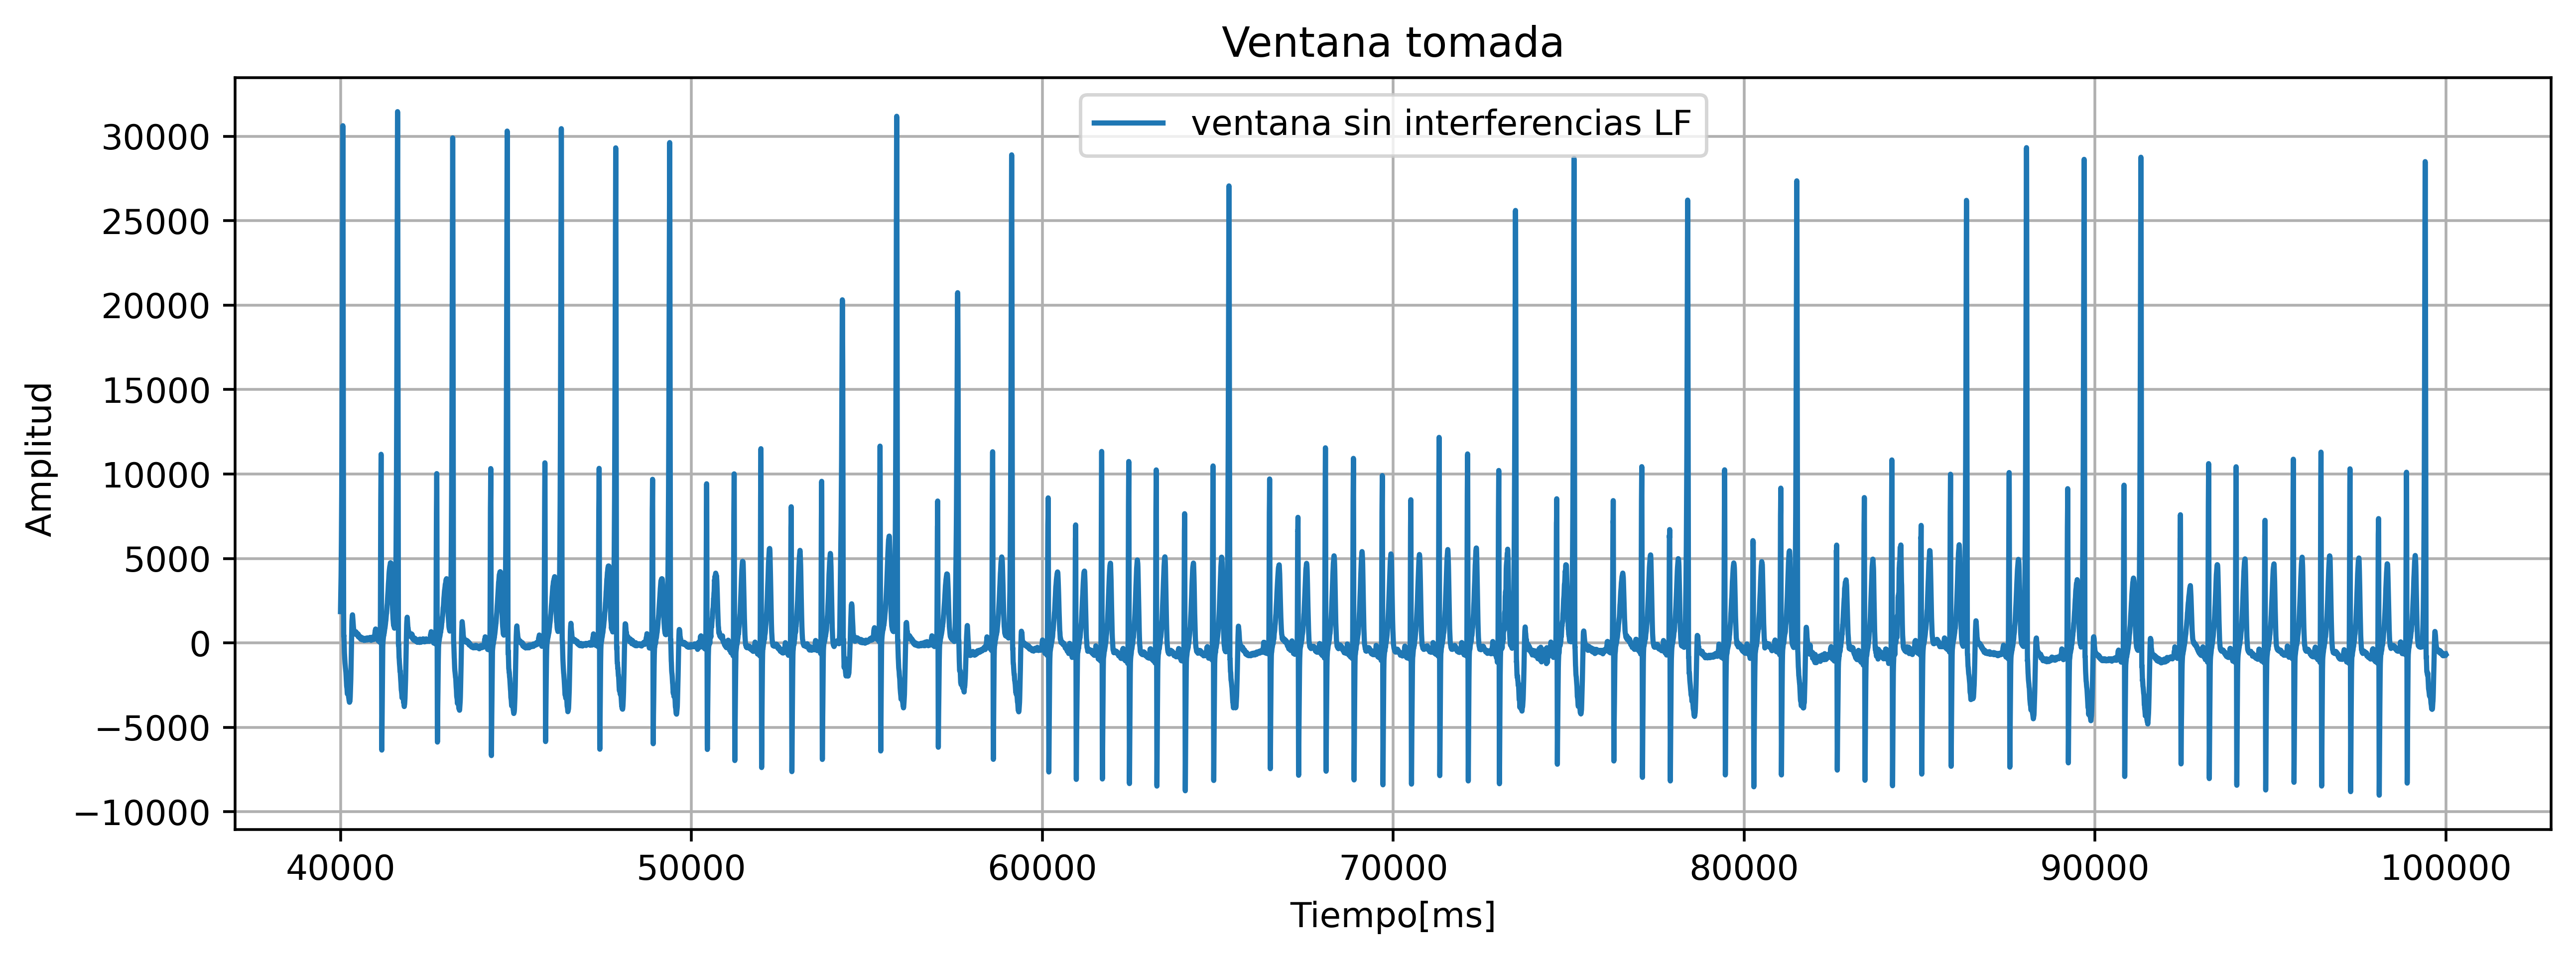

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

ECG = sio.loadmat('ECG_TP4.mat')
ecg_lead = ECG['ecg_lead']
ecg_lead = ecg_lead.flatten('C')
N= len(ecg_lead) # número de muestras


# Establezco una ventana donde considero que el ECG está limpio. Es decir donde no se aprecia ruido de baja frecuencia
t1=40000
t2=100000
win =np.arange(t1,t2,1)

plt.figure("ECG Window",figsize=[12,4],dpi=500)
plt.plot(win,ecg_lead[win],label='ventana sin interferencias LF')
plt.title('Ventana tomada')
plt.xlabel('Tiempo[ms]')
plt.ylabel('Amplitud ')
plt.grid(which='both', axis='both')

axes_ecg_w = plt.gca()
axes_ecg_w.legend()

Como si fuera una receta de cocina, el siguiente paso sería analizar el comportamiento de esta pequeña señal para altas y bajas frecuencias, en otras palabras, analizar el espectro de potencia de la misma. Esto puede parecer un problema, ya que el ECG es un proceso estocástico (quiere decir que contiene diferentes variables que varían respecto al tiempo) no podemos calcular la transformada de Fourier del proceso en sí mismo. Pero podemos obtener una representación del proceso en el dominio de la frecuencia si expresamos la transformada de Fourier en términos de un promedio del conjunto de realizaciones. Básicamente vamos a analizar esta señal de una manera más bien estadística, en otras palabras, <b>estimaremos espectralmente</b> su densidad de potencia.

### <center> Estimación espectral: El Periodograma </center>

A partir de este momento vamos a tratar de estimar la densidad espectral de potencia de una señal de un proceso aleatorio estacionario en sentido amplio (WSS). El espectro de potencia es la transformada de Fourier de la secuencia de autocorrelación, por lo tanto, estimar el espectro de potencia es equivalente a estimar la autocorrelación. Esto parece sencillo, ya que, si conocemos x(n) para todo n, para estimar el espectro únicamente tendremos que calcular la secuencia de autocorrelación $r_x(k)$ y posteriormente hallar la transformada de Fourier. Pero existen dificultades en este proceso. 
Por ejemplo, la cantidad de datos disponible no es infinita y, en muchos casos, puede que dispongamos de un conjunto de datos pequeño e insuficiente. Otro problema es que la señal puede estar contaminada con ruido o con una señal interferente, por lo tanto, la estimación espectral implica estimar $S_x(e^{jw})$ a partir de un número finito de medidas ruidosas de x(n). Por este motivo se desarollaron algunas técnicas para estimar la DEP, entre estas vamos a utilizar <b>el periodograma</b>, o más aún en una de sus variantes, el método de Welch.


Supongamos que $x_N(n)$ es un proceso finito de longitud N, que es igual a x(n) dentro del intervalo [0;N-1] y cero fuera de este, es decir:

$$x_N(n)=\left\{\begin{matrix}
x(n) & 0\leq n< N\\  
0 & e.o.c.
\end{matrix}\right.$$

De esta manera, podemos considerar $x_N(n)$ como el producto de x(n) con una ventana rectangular $w_R(n)$:
$$ x_N(n) = w_R(n)x(n) $$

Y en términos de $x_N(n)$, podemos expresar la secuencia de autocorrelación estimada como:

$$ \hat{r_x}(k)=\frac{1}{N} \sum_{n=-\infty }^{\infty}x_N(n)x_N^*(n-k)=\frac{1}{N}x_N(n)x_N^*(-k) $$

Tomando la transformada de Fourier y aplicando el teorema de la convolución, obtenemos el <b>periodograma</b>:

$$
\hat{S}_{per}(e^{j\omega})= \frac{1}{N}X_N(e^{j\omega})X_N^*(e^{j\omega})= \frac{1}{N}\left | X_N(e^{j\omega}) \right |^2
$$

Donde $X_N(e^{j\omega})$ es la transformada discreta de Fourier de N puntos de la secuencia $x_N(n)$. Es decir:

$$
X_N(e^{j\omega})=\sum_{n=-\infty }^{\infty }x_N(n)e^{-jn\omega}=\frac{1}{N}\sum_{n=0}^{N-1}x(n)e^{-jn\omega}
$$

De esta manera, <u>el periodograma es proporcional al cuadrado del módulo de la transformada discreta de $x_N(n)$</u>, y puede calcularse facilmente como:
$$
x_N(n)\overset{DFT}{\rightarrow}X_N(k)\rightarrow \frac{1}{N}\left | X_N(k) \right |^2=\hat{S}_{per}(e^{j2\pi k/N})
$$


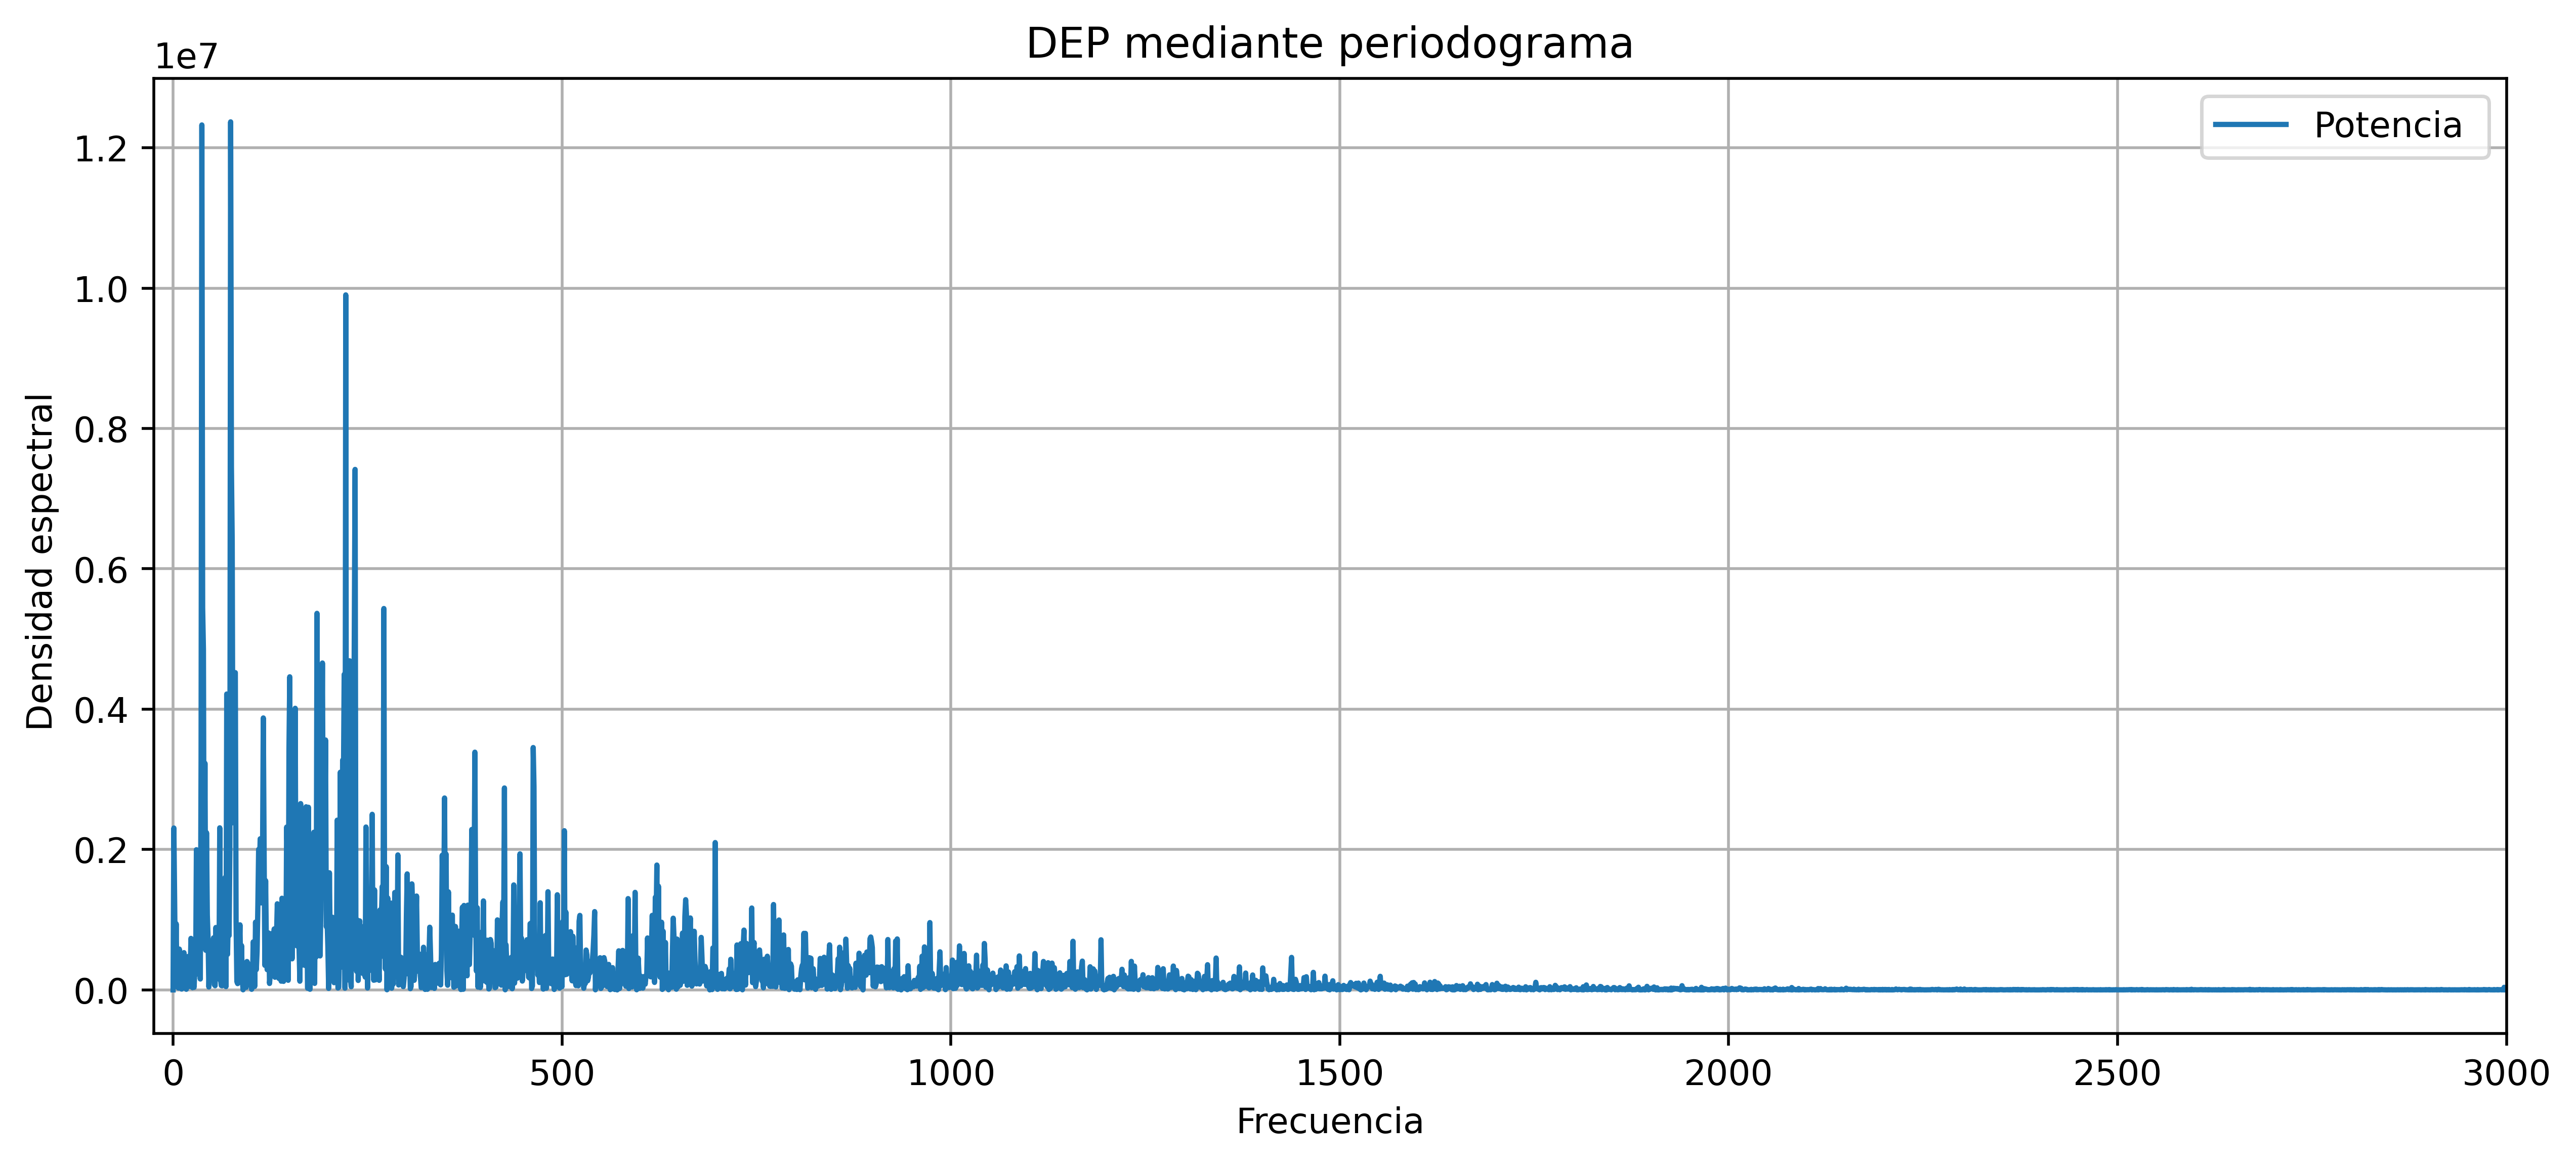

In [2]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio

ecg_w = ecg_lead[t1:t2]
fs=1000 #Hz
f, Pxx = sig.periodogram(ecg_w, fs)

plt.figure("DEP mediante periodogram",figsize=[12,5],dpi=500)
plt.plot(Pxx,label ='Potencia ')
plt.title('DEP mediante periodograma')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad espectral ')
plt.grid(which='both', axis='both')
plt.xlim(-25,3000,1)


axes_periodogram = plt.gca()
axes_periodogram.legend()

### <center> Prestaciones del periodograma </center>
El periodograma parece una solución eficáz a nuestro problema de estimar espectralmente la densidad de potencia de nuestra señal, pero la verdad  es que este método se queda bastante corto. Con el tiempo surgieron nuevas modificaciones que mejoran su fiabilidad y estimación, como por ejemplo el periodograma de Welch, que es con el que se trabajó en este experimento. Pero antes de meternos en lo que consideramos una version más refinada del periodograma tradicional, analizaremos por qué consideramos al periodograma tradicional muy poco fiable y por qué nos debemos inclinar por otro método.

##### Sesgo del periodograma
Definimos el sesgo de un estimador a la diferencia entre el valor esperado y el valor numérico del parámetro que estima. Para que nuestro estimador sea consistente debe ser asintóticamente insesgado, esto quiere decir, que el valor esperado converga al valor verdadero. Esto pasa ya que esta condición se cumple cuando el número de datos de nuestra x(n) tiende a infinito, de hecho, definimos el periodograma a travez de una ventana $w_R(n)$ de N muestras. Para que nuestro estimador cumpla con esta condición la ventana que agarremos debe ser lo suficientemente grande como para que $N\rightarrow \infty $. Por ejemplo, para una ventana de Barlett (triangular).

$$
E\left \{ \hat{S}_{per}(e^{j\omega}) \right \}=\frac{1}{2\pi}S_x(e^{j\omega})*W_B(e^{j\omega})
$$

##### Resolución del periodograma
Supongamos que utilizamos la ventana de Barlett para definir nuestro periodograma. La ventana de Barlett se caracteriza por ser triangular y sigue la siguiente forma:

$$
w_B(k)=\left\{\begin{matrix} 
\frac{k-N}{N} & ;\;\;\ \left | k \right |\leq N\\ 
0 & ;\;\;\ e.o.c.
\end{matrix}\right.
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; ;\;\;\; con\; k=0,1,2,...N-1
$$


Donde su transformada de Fourier es:

$$
W_B(e^{j\omega})=\frac{1}{N}\left ( \frac{sin(N\omega/2)}{sin(\omega /2)}\right )
$$

## <img src="./RespFrec_FFT_Ventana_Barlett.png" align="center" width="80%" />

Si observamos la igualdad y la imagen de arriba notaremos que la anchura del lóbulo principal de $W_B(e^{j\omega})$ crece cuando la longitud de los datos decrece y que para un valor dado de N, existe un límite en la proximidad de dos sinusoides o procesos de banda estrecha para que dichas componentes puedan ser resueltas o discriminadas. Una forma de definir esta resolución es imponer a $\Delta\omega$ la anchura del lóbulo principal del espectro de la ventana $W_B(e^{j\omega})$, a su "potencia mitad" o a 6 dB. Para la ventana de Barltett,y por tanto la resolución del periodograma, es la siguiente:

$$
Res\left [ \hat{S}_{per} \right ] = 0.89\frac{2\pi}{N}
$$


##### Varianza del periodograma
Con la varianza es donde tendremos problemas, para que nuestro estimador sea consistente la varianza debe hacerse cero cuando $N\rightarrow \infty $. Se puede demostrar que esto no se cumple y, peor aún, tampoco tiende a acercarse a este valor, de hecho, la varianza queda definida como:
$$ Var\left \{ \hat{S}_{per}(e^{j\omega }) \right \} = S^2_x(e^{j\omega }) $$

Por eso diremos que el periodograma <b>no es un estimador consistente del espectro de potencia</b>.


***

### <center> El Método de Welch </center>

Ahora que tenemos una idea  de lo que es el periodograma, lo siguiente es hablar sobre el método utilizado en este trabajo para diseñar nuestro filtro pasabanda. El promedio de periodogramas modificados, el método de Welch, propone dos modifaciones al método de Barlett, no nombrado acá pero que se tratará de explicar sin recurrir a este. Estas dos propuestas son: la primera que una secuencia x(n) se puedan superponer con otra, y la segunda es permitir que una ventana w(n) sea aplicada a cada secuencia, produciendo así un conjunto de <b>periodogramas modificados</b> que pueden promediarse.

#### Solapamiento de segmentos de datos: Overlap
Asumiendo que entre dos secuencias sucesivas existe un desplazamiento de D puntos y que cada secuencia consta de L puntos, la secuencia iésima viene determinada por la expresión:

$$ X_i(n)=x(n+iD) \;\;\;\;\;\; n=0,1,2,...,L-1$$

El solapamiento entre dos secuencias consecutivas $x_i(n)$ y $x_{i+1}(n)$ es L-D. Siendo K el número de secuencias y N la longitud total de puntos, entonces:

$$N=L+D(K-1)$$

Si se permite un solapamiento del 50% (D=L/2), entonces:

$$K=2\frac{N}{L}-1$$

De esta manera se mantiene una resolución pero doblando la cantidad de secuencias(K).

#### Enventanado de cada secuencia
La segunda propuesta consiste en enventanar cada secuencia  $x_i(n)$ con una ventana general $w(n)$ (no sólo con la ventana rectangular), antes de calcular el periodograma. De esta manera se obtiene un periodograma modificado por cada secuencia enventanada.

Sabiendo que el periodograma es:
$$
\hat{S}_{per}(e^{j\omega})= \frac{1}{N}\left | X_N(e^{j\omega}) \right |^2
$$

Dado que $X_N(n)$ es la tranformada de nuestra sencuencia $x_i(n)$, si la desplazamos D puntos y la enventanamos con una ventana $w(n)$:

$$
x_i(n)=w(n)x(n+iD)
$$

Entonces el í-esimo periodograma modificado es:
$$
\hat{S}_{per_M}^{(i)}(e^{jw})=\frac{1}{LU}\left | \sum_{n=0}^{L-1}w(n)x_i(n)e^{-jnw} \right |^2
$$

El estimador de Welch es el promedio de los periodogramas modificados:

$$
\hat{S}_{W}(e^{jw})=\frac{1}{K} \sum_{i=0}^{K-1}\hat{S}_{per_M}^{(i)}(e^{jw})
$$

Donde L es la cantidad de puntos de la secuencia, K es el número de secuencias y U es una constante dada por:

$$
U=\frac{1}{L}\sum_{n=0}^{L-1}\left | w(n) \right |^2
$$

---
### Propiedades del método de Welch

 * <b>Periodograma de Welch</b>

$$
\hat{S}_W(e^{j\omega})=\frac{1}{KLU}\sum_{i=0}^{K-1}\left | \sum_{n=0}^{L-1}w(n)x(n+iD)e^{-jn\omega} \right |^2
$$

$$
U=\frac{1}{L}\sum_{n=0}^{L-1}\left | w(n) \right |^2
$$

* <b>Sesgo</b>

$$
E\left \{ \hat{S}_w(e^{j\omega}) \right \}=\frac{1}{2\pi LU}S_x(e^{j\omega})*\left | W(e^{j\omega}) \right |^2
$$

* <b>Resolución</b>

Dado que la resolución establece qué tan cerca pueden ubicarse dos secuencias antes de que no puedan resolverse, esta <b>dependerá de la ventana utilizada.</b>

* <b>Varianza (asumiendo un overlap del 50% y una ventana triangular)</b>

$$
Var\left \{ \hat{S}_W(e^{j\omega}) \right \}\approx \frac{9}{16}\frac{L}{N}S_x^2(e^{j\omega})
$$


Entonces, viendo que si solapamos secuencias de L puntos en un 50% podremos lograr una varianza mucho menor que la obtenida en el periodograma tradicional. Además, si bien la resolución dependerá de la ventana utilizada veremos que tendremos una aproximadamente igual, pero doblando el número de secuencias. Con esto concluímos que el método de Welch es más efectivo que el periodograma tradicional y por este motivo trabajaremos sobre ese método.

****



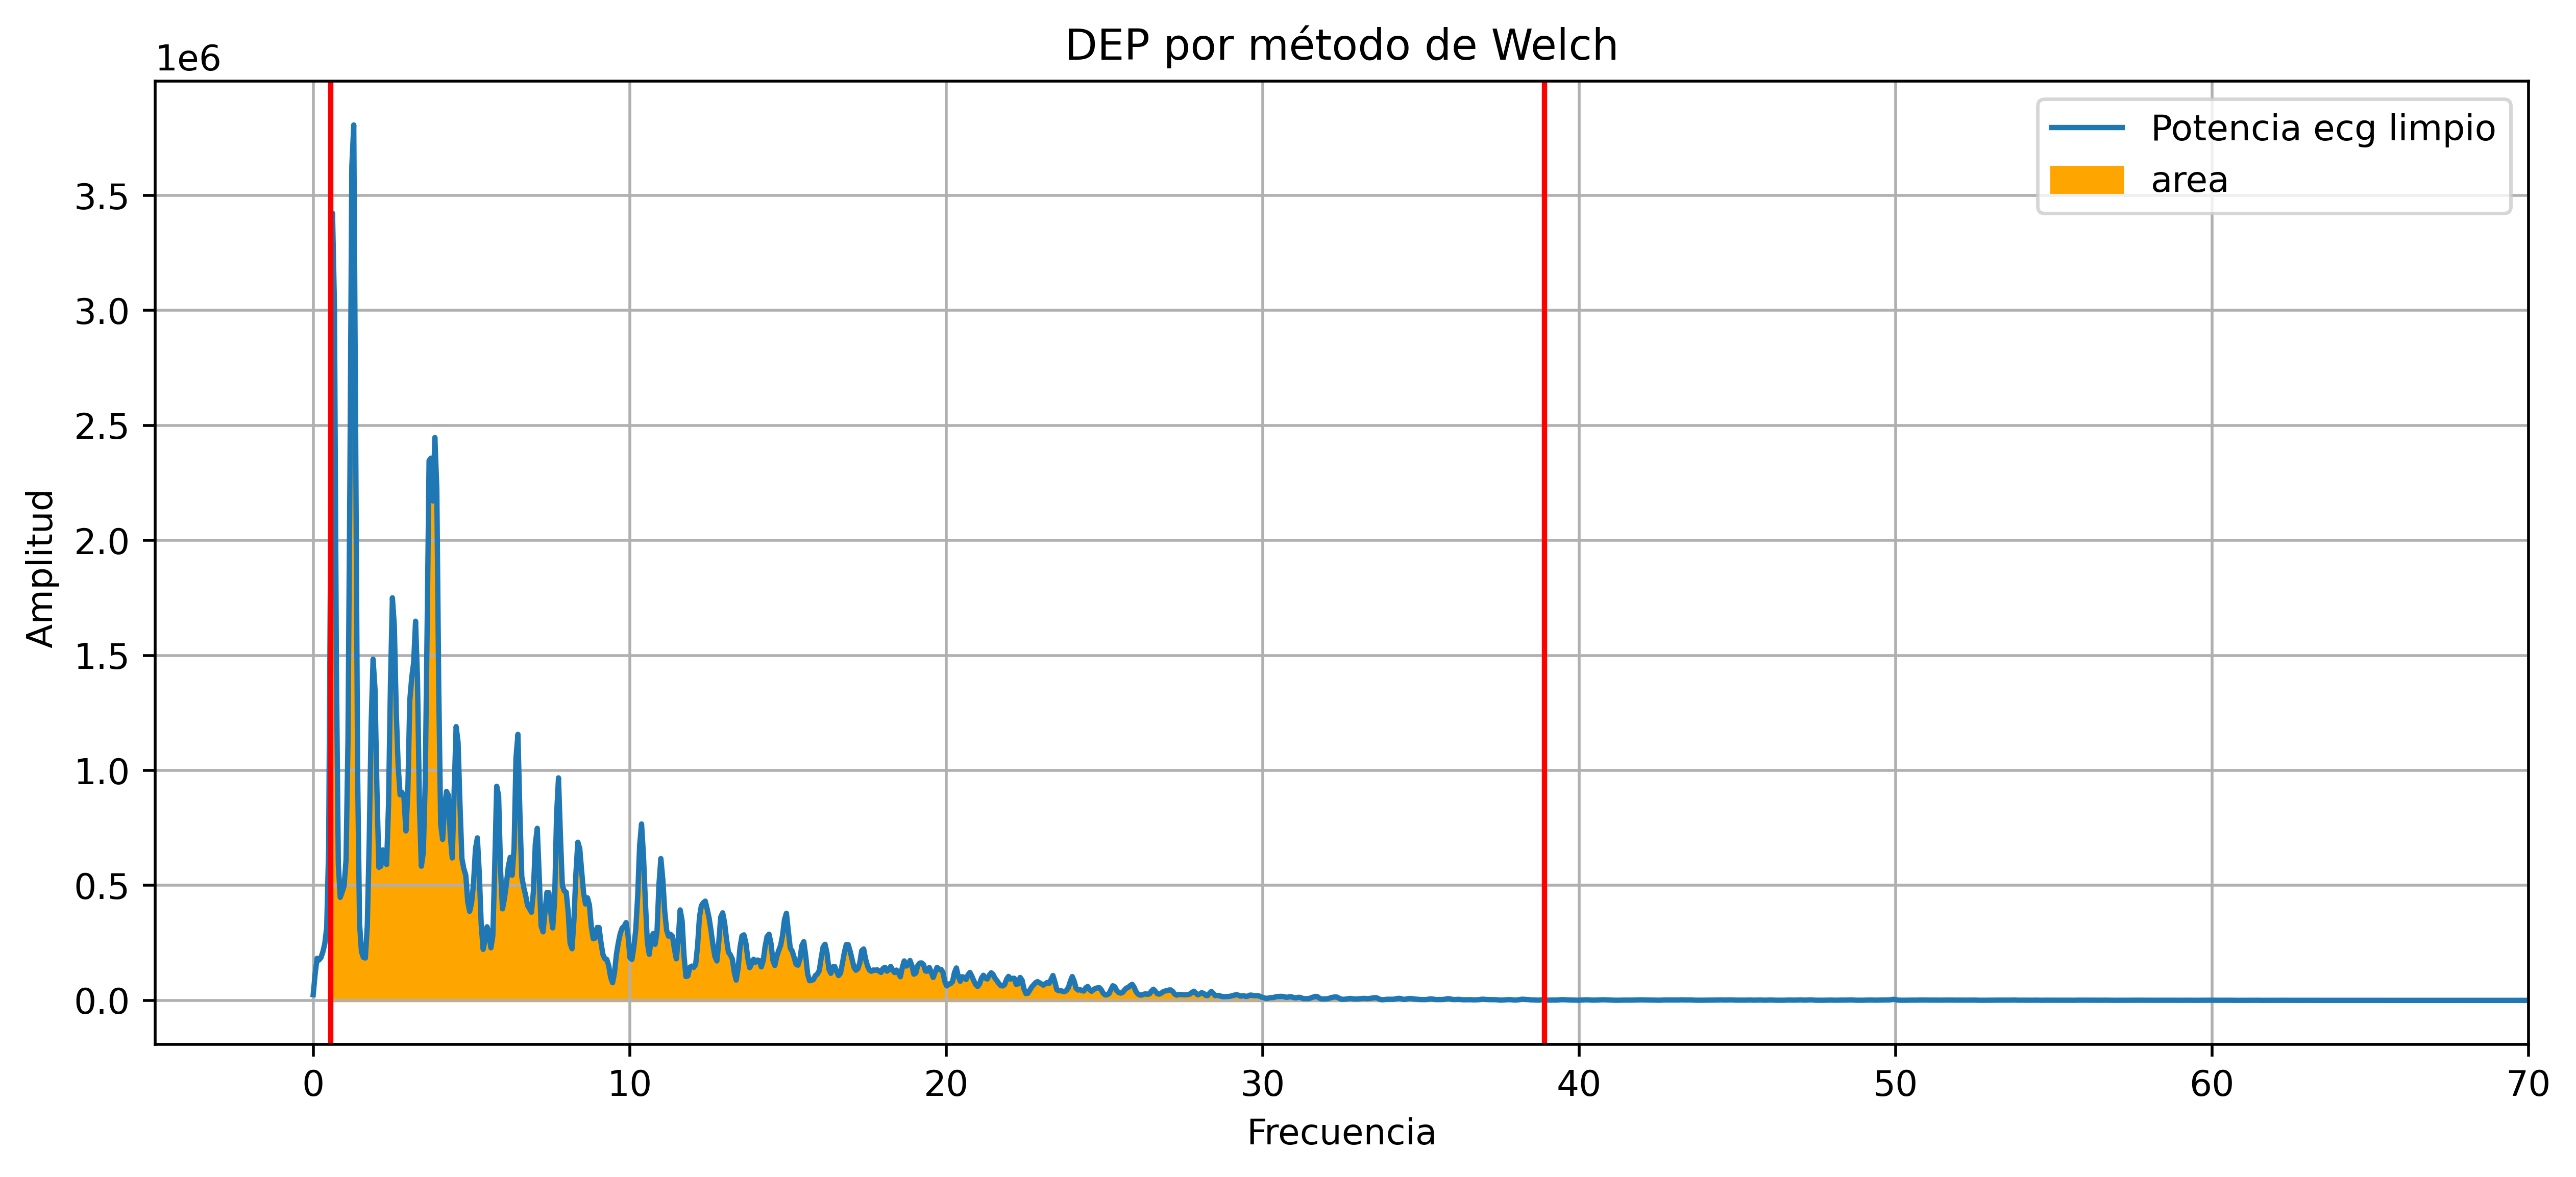

In [3]:
t1=40000
t2=100000
ecg_w = ecg_lead[t1:t2]
n_w = len(ecg_w)


Fxx,Pxx=sig.welch(ecg_w,fs,window='bartlett',nperseg=8192,noverlap=8192/2, nfft=2*8192)

#Calculo de la proporción de área
f_total = (Pxx>0)
f_paso = (Fxx>=0.6) & (Fxx<=39) # Eleccion de las frecuencias de corte
area_total = np.trapz (Pxx[f_total])
area_part = np.trapz (Pxx[f_paso])
ratio = (area_part/area_total)*100


plt.figure("Densidad de potencia",figsize=[12,5],dpi=500)
plt.plot(Fxx,Pxx,label ='Potencia ecg limpio')
plt.title('DEP por método de Welch')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud ')
plt.grid(which='both', axis='both')
plt.xlim(-5,70,1)

section = np.arange(9,638,1)
plt.fill_between(Fxx,Pxx,color='orange',where=Fxx>=0.549316,label='area')

plt.axvline(x=0.549,color='r')
plt.axvline(x=38.91,color='r')

axes_hdl_P = plt.gca()
axes_hdl_P.legend()

Arriba vemos como utilizando el método de Welch la DEP tiene una resolución más suavizada. Observamos también, que la amplitud más elevada se ubica en la zonas de baja frecuencia y luego tiene a drececer. En 50 Hz aparece un sobrepico que nos indica que hay una contaminación debido a la red eléctrica, lo cual es normal al tomar un ECG. En Naranja aparece el area que tomamos para diseñar nuestra plantilla y las líneas verticales en rojo indican las frecuencias de corte de nustro pasabanda. 

## <center> Diseño de la plantilla </center>

Un filtro pasabanda es un filtro que deja pasar determinada rango de frecuencias y atenúa el resto. Una plantilla de un filtro pasabanda consta de 3 partes:
* Una banda de Stop, que contiene una frecuencia de stop $f_{s_0}$ y una atenuación mínima $(\alpha_{min_0})$
* Una banda de paso, que contiene dos frecuencias de corte $f_{c_0} y f_{c_1}$ y una atenuación máxima $(\alpha_{max})$
* Una banda de Stop, que contiene una frecuencia de stop $f_{s_1}$ y una atenuación mínima  $(\alpha_{min_1})$

## <img src="./plantilla_bp.png" align="center" width="80%" />

La imagen es asimétrica a propósito, ya que no es necesario que la distancia entre $f_{s_0}$ y $f_{c_0}$ sea igual a la distancia entre $f_{c_1}$ y $f_{s_1}$, ni que $\alpha_{min_0}$ sea igual a $\alpha_{min_1}$.

#### Frecuencias de corte

Para seleccionar las frecuencias de cortes medimos el area total bajo el espectro y la dividimos por una parte de la misma de modo que la proporción entre ambas esté por encima del 95%. De ese modo nos aseguramos que tengamos el 95% de información dentro de nuestra banda de paso, lo cual nos da el pie a que posiblemente tengamos un buen filtro.

In [4]:
from pandas import DataFrame
from IPython.display import HTML

areas = [ 
                   [area_total,area_part,ratio], # <-- completar acá
                 ]
df = DataFrame(areas, columns=['Total', 'Tomada', 'Proporcion [%]'],index=['Area'])
HTML(df.to_html())

Como se ve, tenemos una proporción de área por encima del 96% por lo cual nuestras frecuencias están aparentemente bien elegidas. Dicho esto, nuestras frecuencias de corte serán $0.6Hz$ y $39Hz$.

#### Frecuencias de Stop

Para la frecuencias de stop se optó por ser más permisivos. No hubo un criterio muy exigente, de hecho, se tanteo entre posibles frecuencias tratando de lograr la menor distorsión en la banda de paso, y así tratar de lograr el mejor filtro posible, esto es, ser inocuo en la banda de paso y rechazar las frecuencias fuera de esta. Si bien más arriba obtuvimos las frecuencias de corte inferior y superior, vemos que la inferior está muy cerca del 0, por lo que decidimos correrla hacia $1Hz$ y usar el $0.6Hz$ como nuestra $f_{s_0}$. Por otro lado eligimos la $f_{s_1}$ como $40Hz$.

#### Atenuaciones

En el caso de las atenuaciones, sigue el mismo criterio. Se eligieron conforme no sean invasivas a nuestro filtrado, solo que por facilidad se decidió que  $\alpha_{min_0} = \alpha_{min_1}$.

Entonces, la plantilla:

In [5]:
fs0=0.6 #Hz
fc0=1 #Hz
fc1=38.1 #Hz
fs1=40 #Hz

a_min=40 #dB
a_max=0.5 #dB

---
## Filtros FIR e IIR


Una vez diseñada nuestra plantilla podemos proseguir a filtrar nuestro ECG, en primera instancia, mediante las <b> metodologías lineales </b>. Dentro de este tipo de filtrado se encuentran los filtros de respuesta al impulso finita (FIR) y los filtros de respuesta al impulso infinita (IIR). Analizaremos su comportamiento contra nuestra plantilla, así también ventajas y deventajas de los mismo.

Supongamos que tenemos una sección de segundo orden analógica y genérica:

$$
T(s)=\frac{\beta_0+\beta_1s+\beta_2s^2}{\alpha_0+\alpha_1s+\alpha_2s^2}
$$

Si queremos pasarla al dominio digital, podriamos usar una transformación bilineal, es decir:

$$
T(z)=T(s)|_{s=2f_s\tfrac{z-1}{z+1}}
$$

donde $f_s$ es la frecuencia de muestreo. Si reemplazamos sobre $s$ y operamos llegaremos a:

$$
T(z)=\frac{Y(z)}{X(z)}=\frac{b_2z^{-2}+b_1z^{-1}+b_0}{a_2z^{-2}+a_1z^{-1}+a_0}
$$

donde $b_m$ y $a_n$ son constantes en funcion de $\beta_m,\alpha_n$ y $f_s$ respectivamente.

Si ahora despejamos $Y(z)$:

$$
Y(z)=\frac{1}{a_0}\left ( \sum_{m=0}^{M}b_mX(z)z^{-m}-\sum_{n=1}^{N}a_nY(z)z^{-n} \right )
$$

y anti-transformamos en Z:

$$
y[k]=\frac{1}{a_0}\left ( \sum_{m=0}^{M}b_mx[k-m]-\sum_{n=1}^{N}a_ny[k-n] \right )
$$

Tendremos el valor de la salida actual y que es lo suficientemente general como para englobar los filtros IIR($a_n\neq 0$) y los FIR($a_n=0$). Mientras que los coeficientes del IIR pueden calcularse mediante la transformada bilineal como vimos hace rato, en el caso de los FIR, los coeficientes $b_m$ pueden calcularse mediante el método de ventanas.

Procedemos a diseñar los filtros:

In [6]:
f_nyq = fs/2 #500 Hz


## IIR
bp_butter = sig.iirdesign(wp=np.array([fc0,fc1])/f_nyq, ws=np.array([fs0,fs1])/f_nyq, gpass=a_max, gstop=a_min, analog=False, ftype='butter', output='sos')
bp_cheby = sig.iirdesign(wp=np.array([fc0,fc1])/f_nyq, ws=np.array([fs0,fs1])/f_nyq, gpass=a_max, gstop=a_min, analog=False, ftype='cheby1', output='sos')



## FIR
#N_Blackman=501 
#N_Hamming=501 

N_Blackman = round((12*f_nyq)/(fc1-fc0))-1 #161 
#N_Hamming = round((8*f_nyq)/(fc1-fc0)) #114

frecs = np.array([0.0,     fs0,     fc0,    fc1,    fs1,   f_nyq ])/f_nyq
gains = np.array([-a_min, -a_min, -a_max, -a_max, -a_min, -a_min ])
gains = 10**(gains/20)

w_blackman = sig.firwin2(N_Blackman, frecs,gains,window='blackmanharris')
#w_hamming = sig.firwin(N_Hamming, [fc0/f_nyq,fc1/f_nyq],pass_zero=False,window='hamming')

Una vez diseñados, analizamos su respuesta en frecuencia:

<ipython-input-7-86d982ea4ef4>:19: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w,20*np.log10(np.abs(h_cheby)), label='IIR Chebyshev')


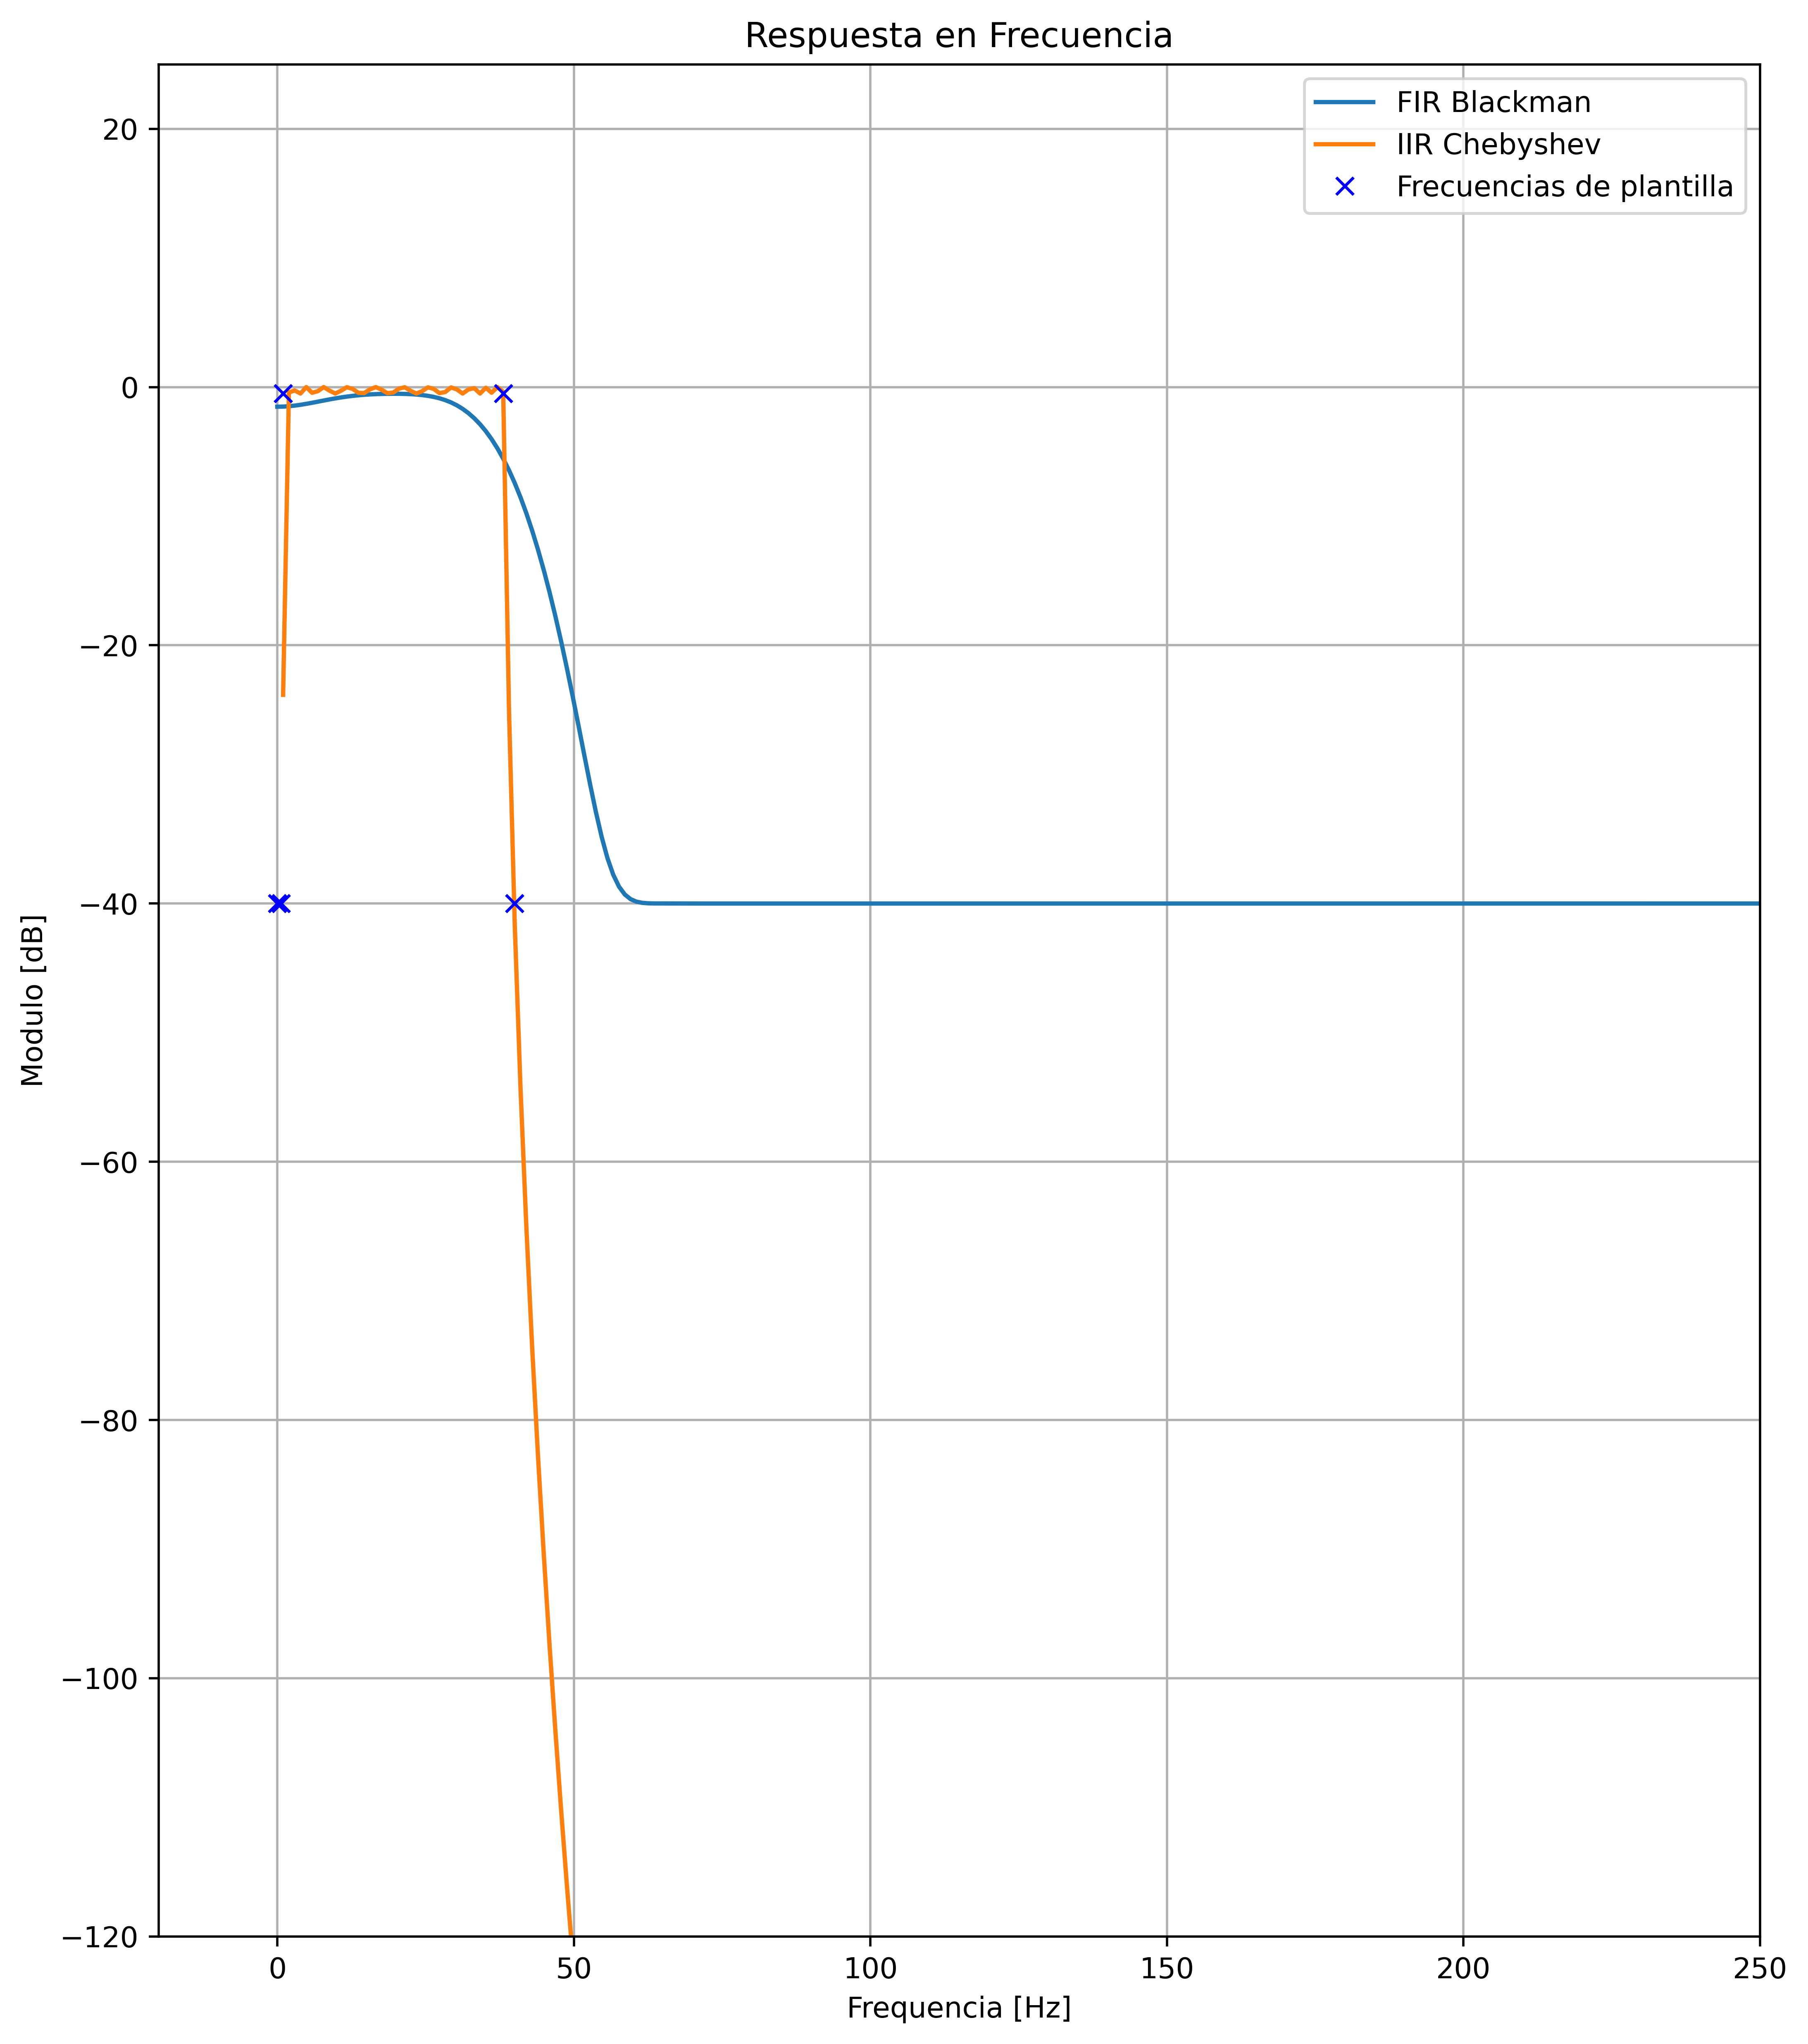

In [7]:
## RESP EN MODULO
#w, h_butter = sig.sosfreqz(bp_butter) #IIR BUTTER
w, h_cheby = sig.sosfreqz(bp_cheby) ##IIR CHEBY
_,H_Blackman = sig.freqz(w_blackman,1) #FIR BLACKMAN
#_,H_Hamming = sig.freqz(w_hamming,[1]) #FIR HAMMING


w=(w/np.pi)*f_nyq# Desnormalizo frecuencia

###### PLOTEOS
plt.figure("Respuesta en frecuencia",figsize=[10,12],dpi=500)

##PLOTEO FIR
plt.plot(w,20*np.log10(np.abs(H_Blackman)), label='FIR Blackman')
#plt.plot(w,20*np.log10(abs(H_Hamming)), label='fir Hamming')

##PLOTEO IIR
#plt.plot(w,20*np.log10(np.abs(h_butter)), label='IIR Butterworth')
plt.plot(w,20*np.log10(np.abs(h_cheby)), label='IIR Chebyshev')


plt.plot(frecs*f_nyq, 20*np.log10(gains), 'bx', label='Frecuencias de plantilla' )

plt.title('Respuesta en Frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid(which='both', axis='both')
plt.axis([-20, 250, -120, 25 ]);

Trazos = plt.gca()
Trazos.legend()

Arriba podemos observar que la respuesta en modulo se ajusta bien al diseño de nuestra plantilla de Filtro Pasabanda. En azul, un IIR Chebyshev, que genera un ripple o un "enrulado" en la banda de paso pero que nos permite ahorrar en orden de nuestra $T(z)$. En naranja, un FIR mediante el método de ventanas, utilizando una ventana Blackman-Harris.

## <center> Resultado aplicando filtros FIR e IIR </center>

### Zonas con interferencias en baja frencuencias

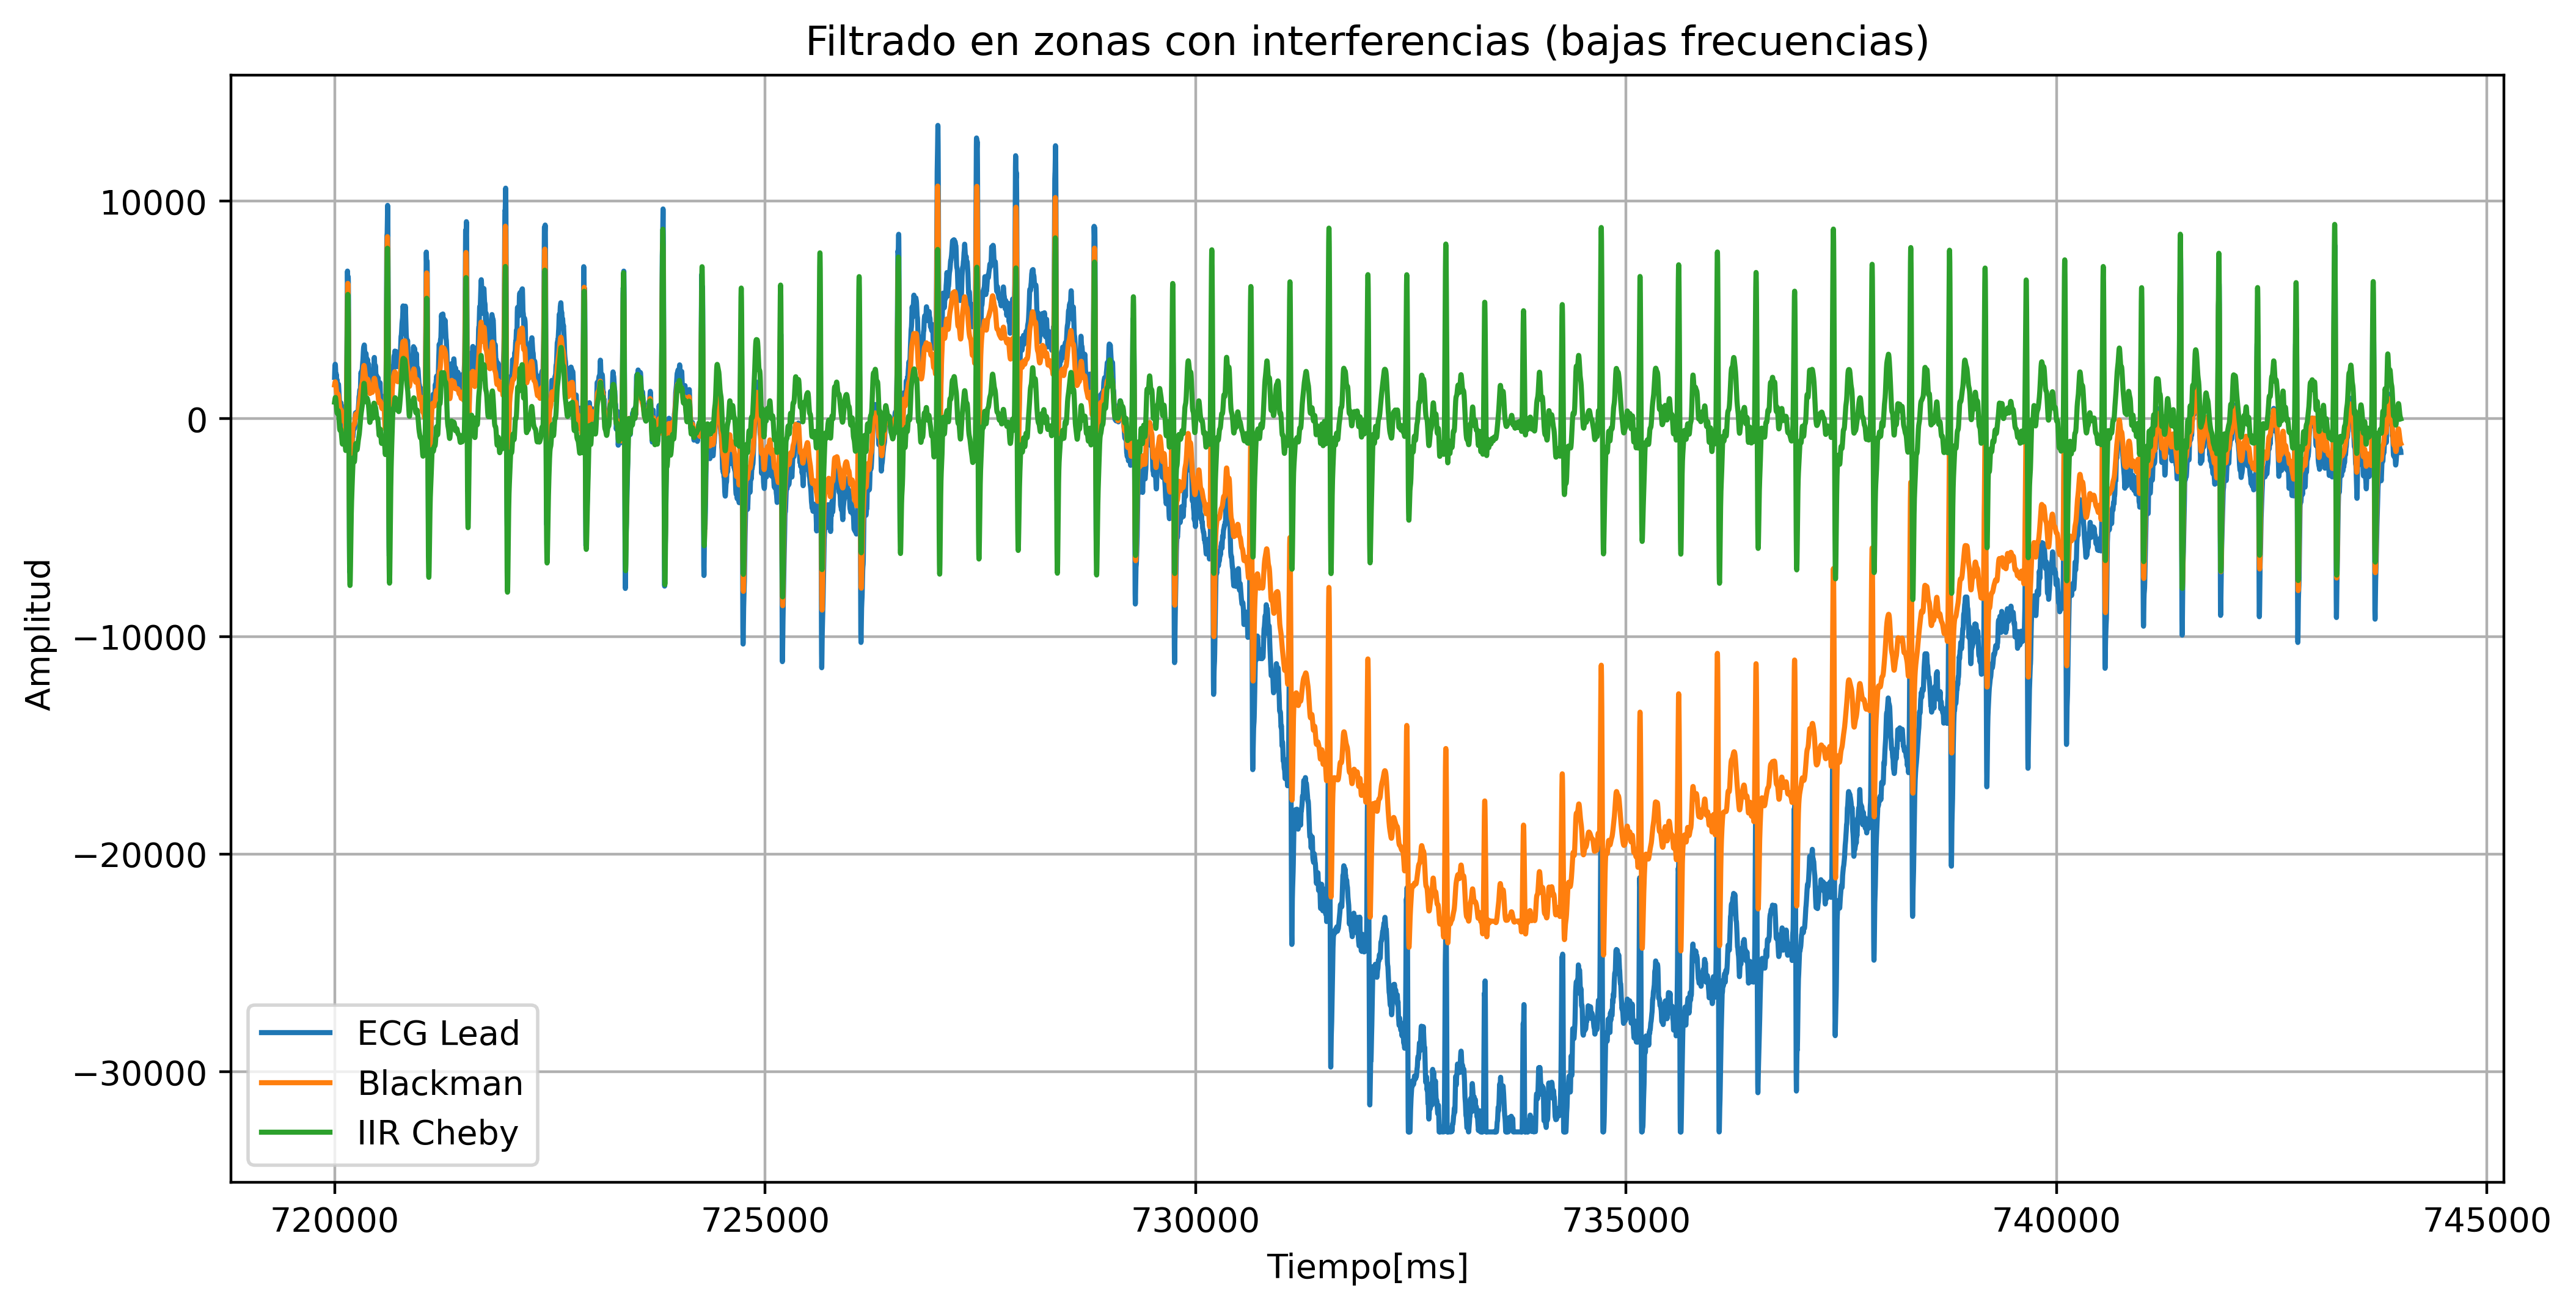

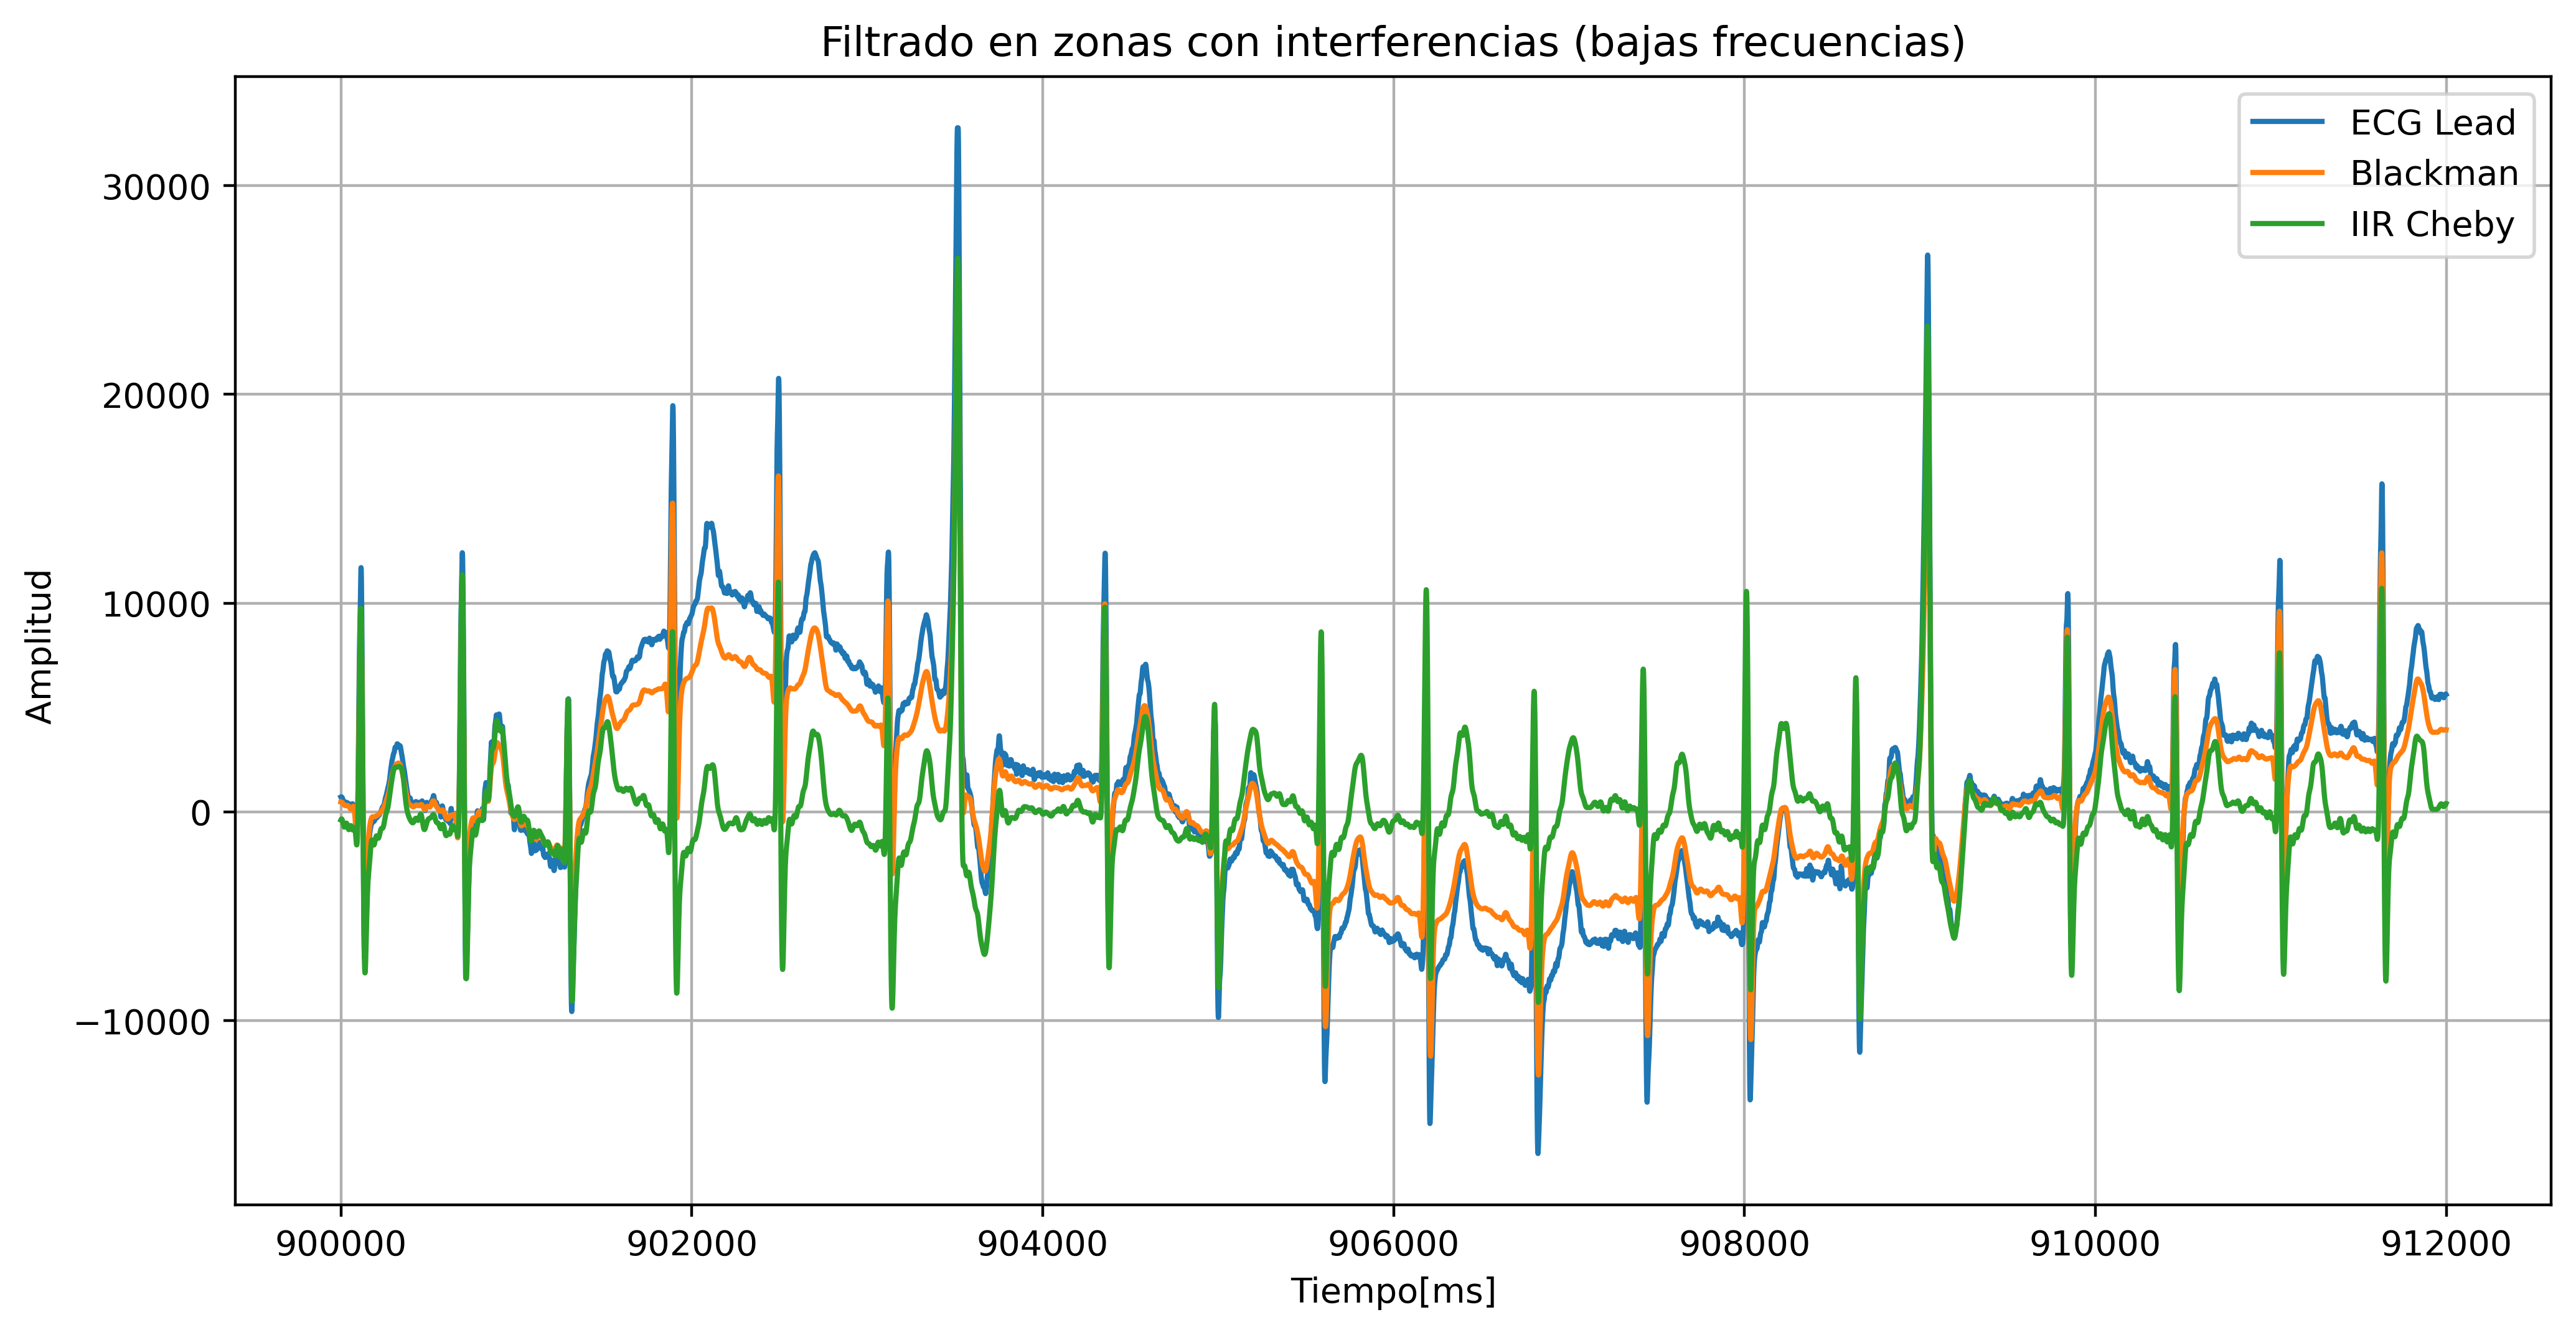

In [8]:
zonas_con_interf_baja_frec = ( 
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )


## ECG FILTRADA POR IIR
#ECG_filtrada_butter = sig.sosfiltfilt(bp_butter,ecg_lead)
ECG_filtrada_cheby = sig.sosfiltfilt(bp_cheby,ecg_lead)

## ECG FILTRADA POR FIR
denominador=1
ECG_filtrada_black = sig.filtfilt(w_blackman,denominador,ecg_lead)

for i in zonas_con_interf_baja_frec:
    zoom = np.arange(i[0],i[1],dtype='int')
    
    plt.figure(figsize=[12,6],dpi=400)
    plt.plot(zoom,ecg_lead[zoom],label='ECG Lead')
    plt.plot(zoom,ECG_filtrada_black[zoom], label='Blackman')
    #plt.plot(zoom,ECG_filtrada_butter[zoom], label='IIR Butter')
    plt.plot(zoom,ECG_filtrada_cheby[zoom], label='IIR Cheby')
    
    plt.title('Filtrado en zonas con interferencias (bajas frecuencias)')
    plt.xlabel('Tiempo[ms]')
    plt.ylabel('Amplitud ')
    plt.grid(which='both', axis='both')

    filtro_int_lf = plt.gca()
    filtro_int_lf.legend()

### Zonas sin interferencias

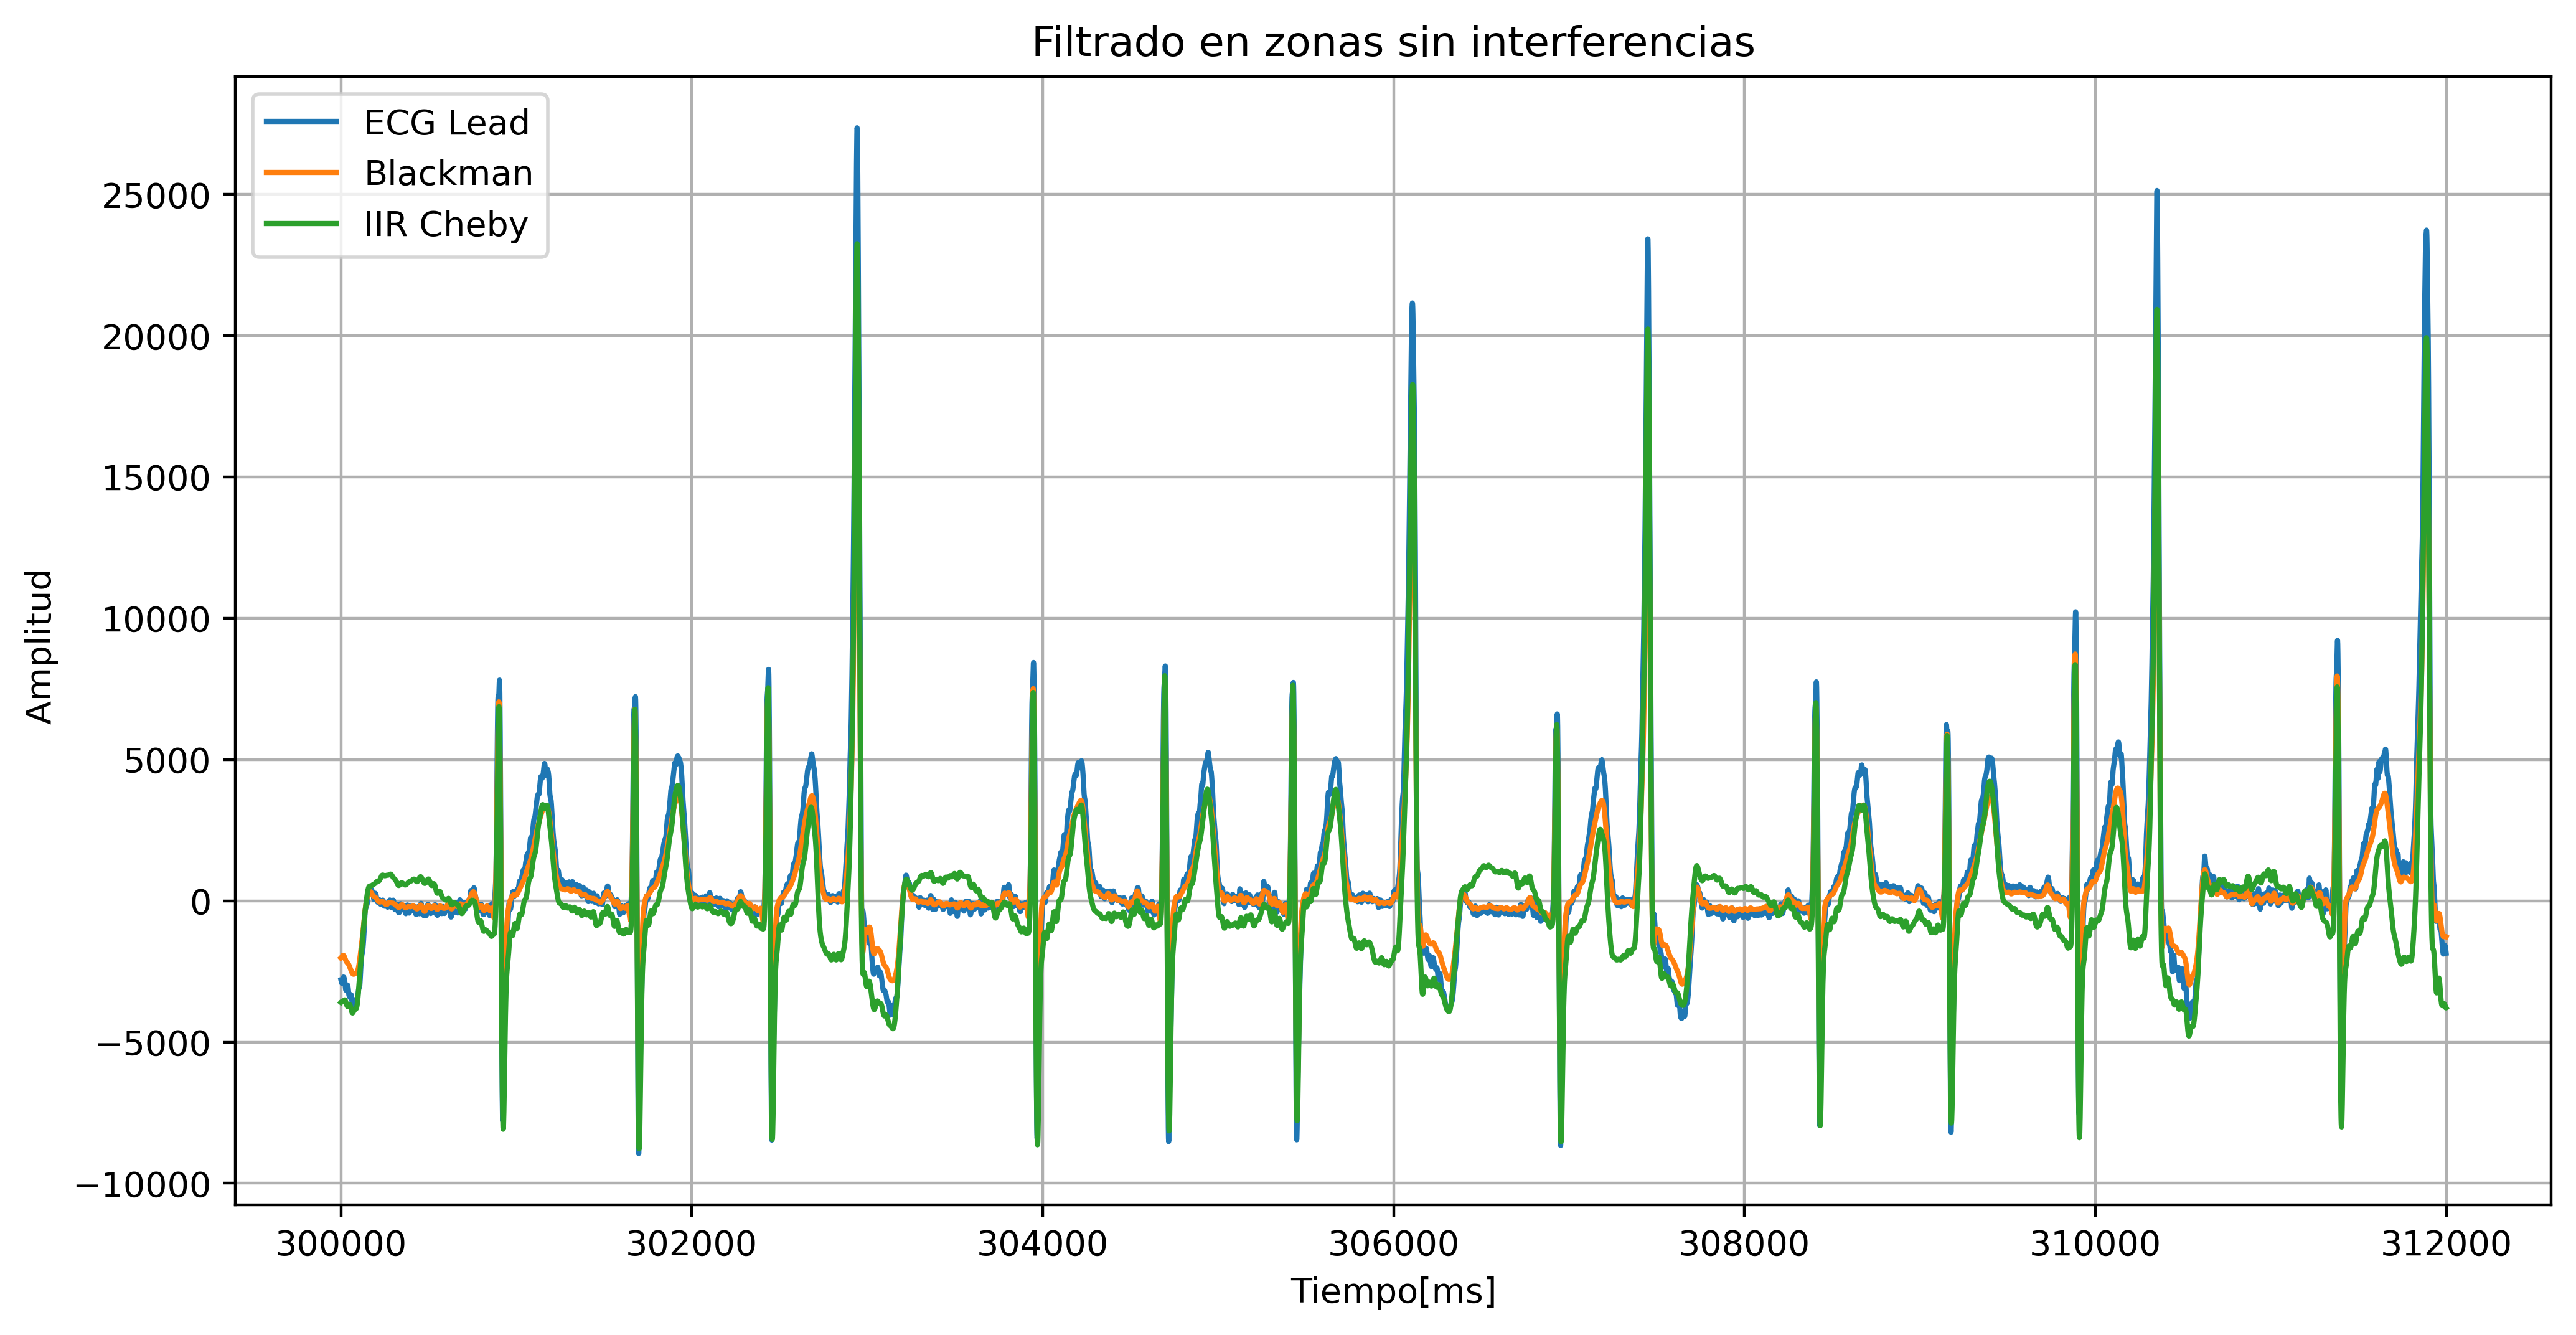

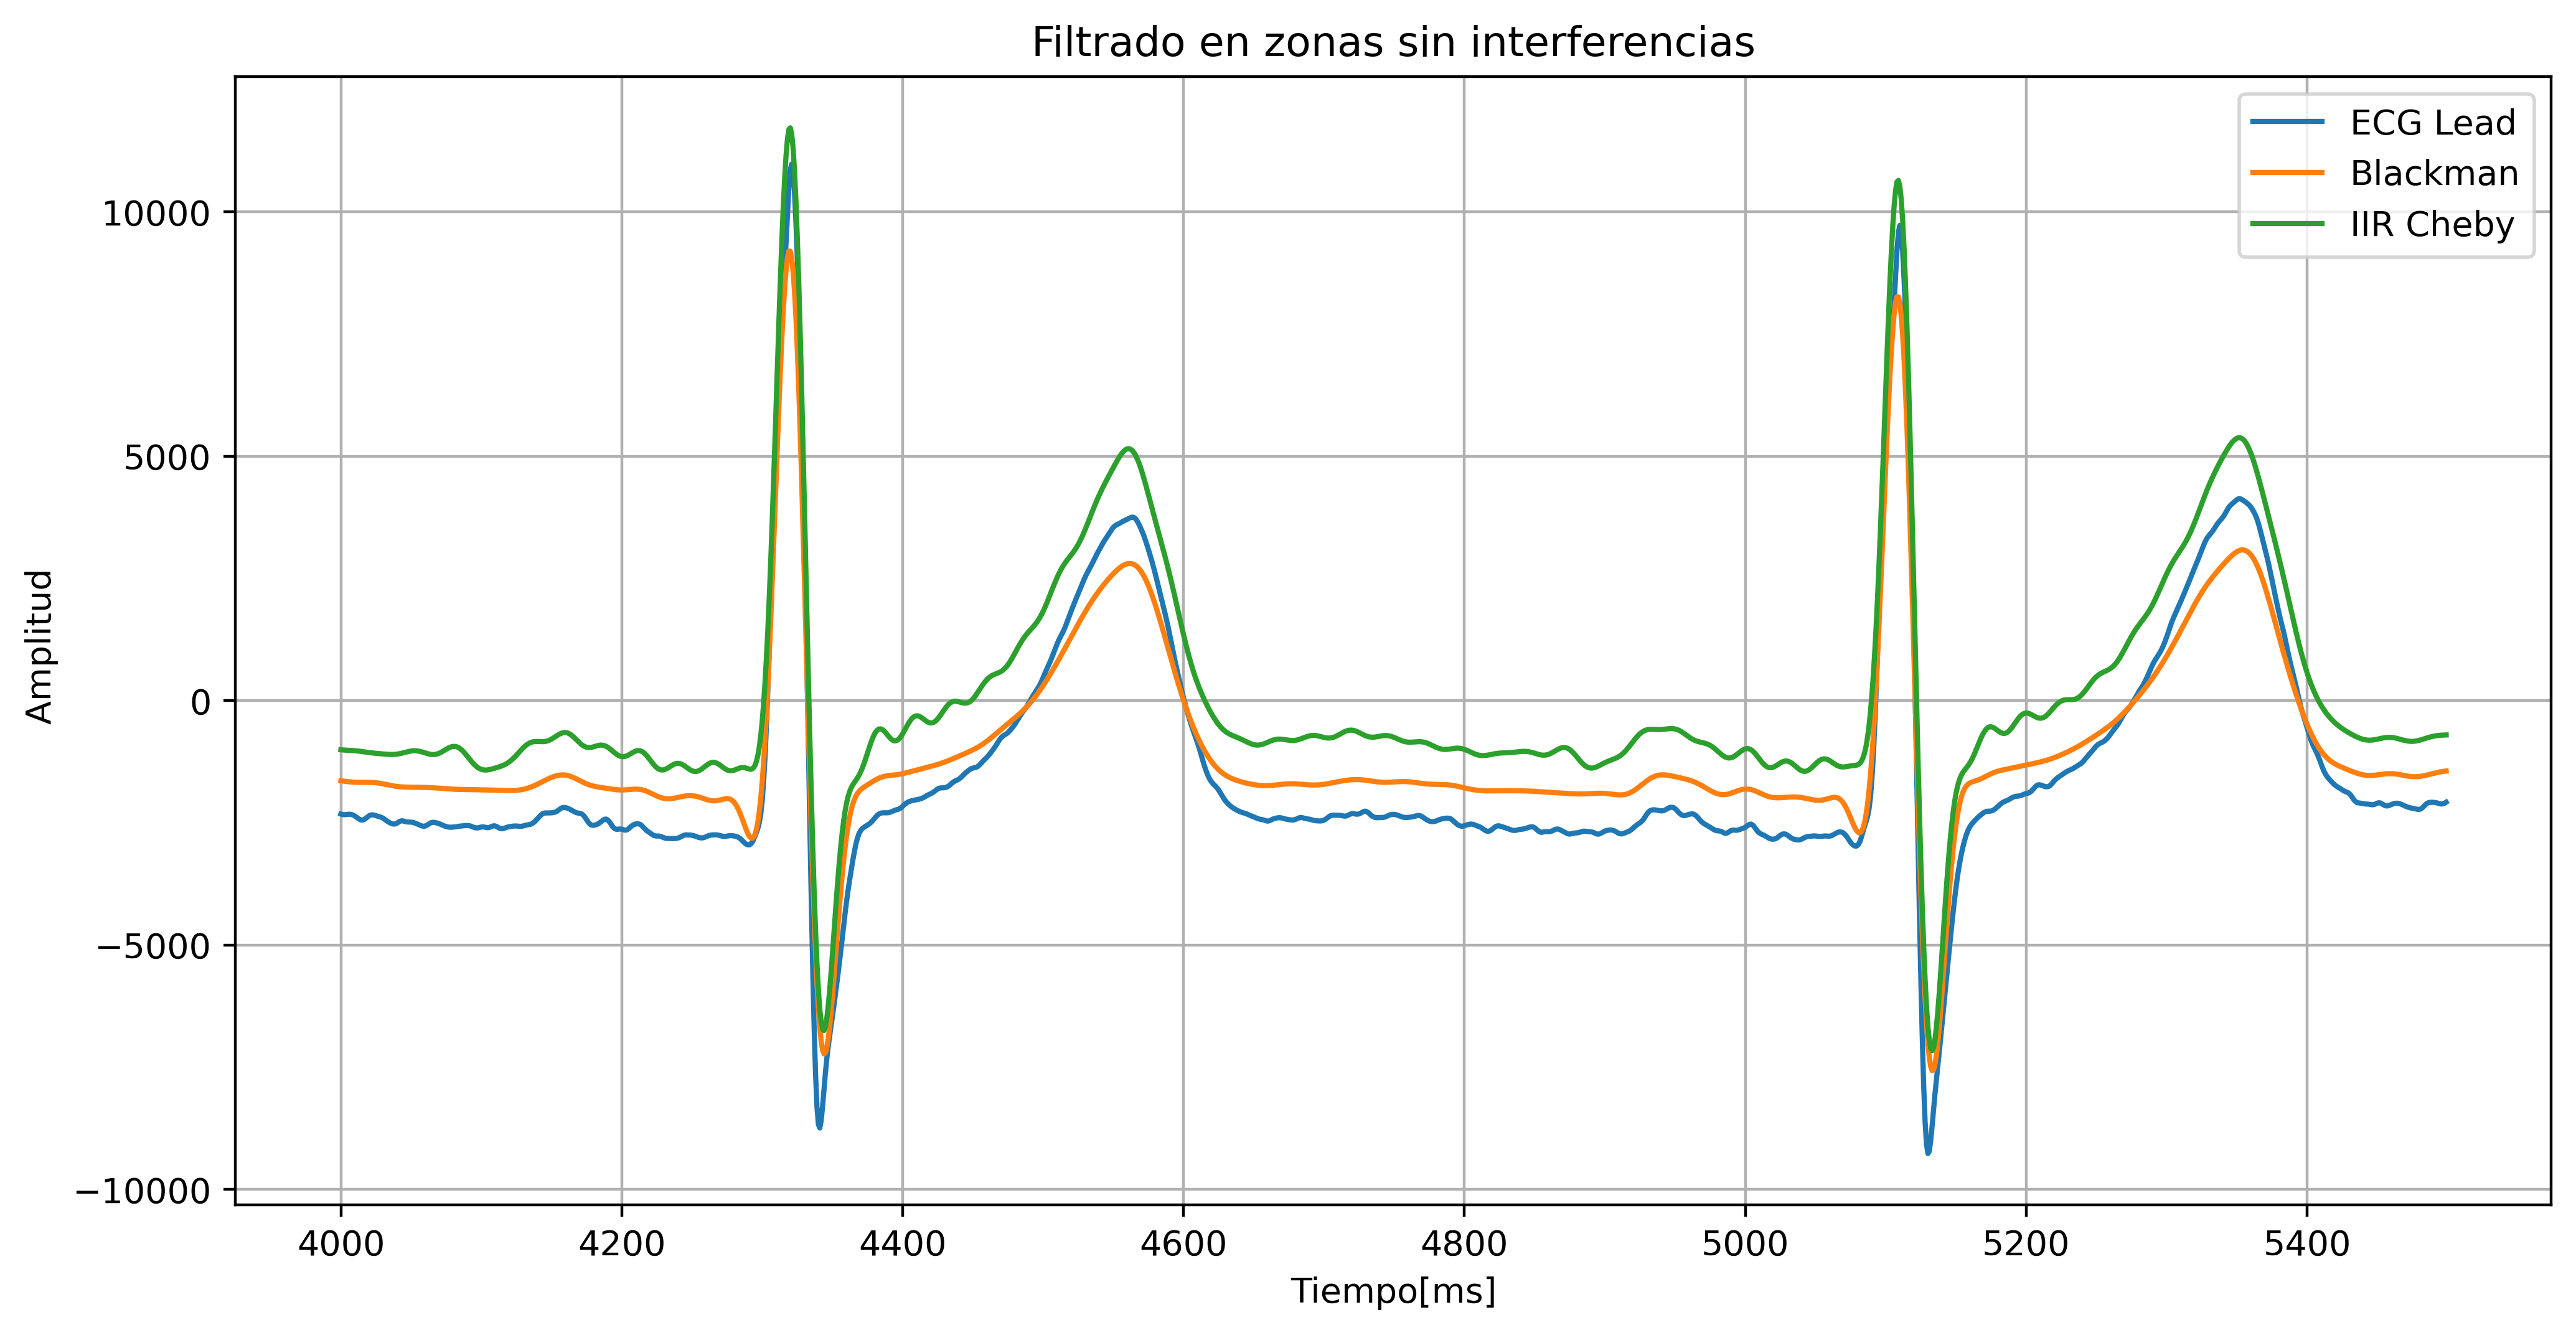

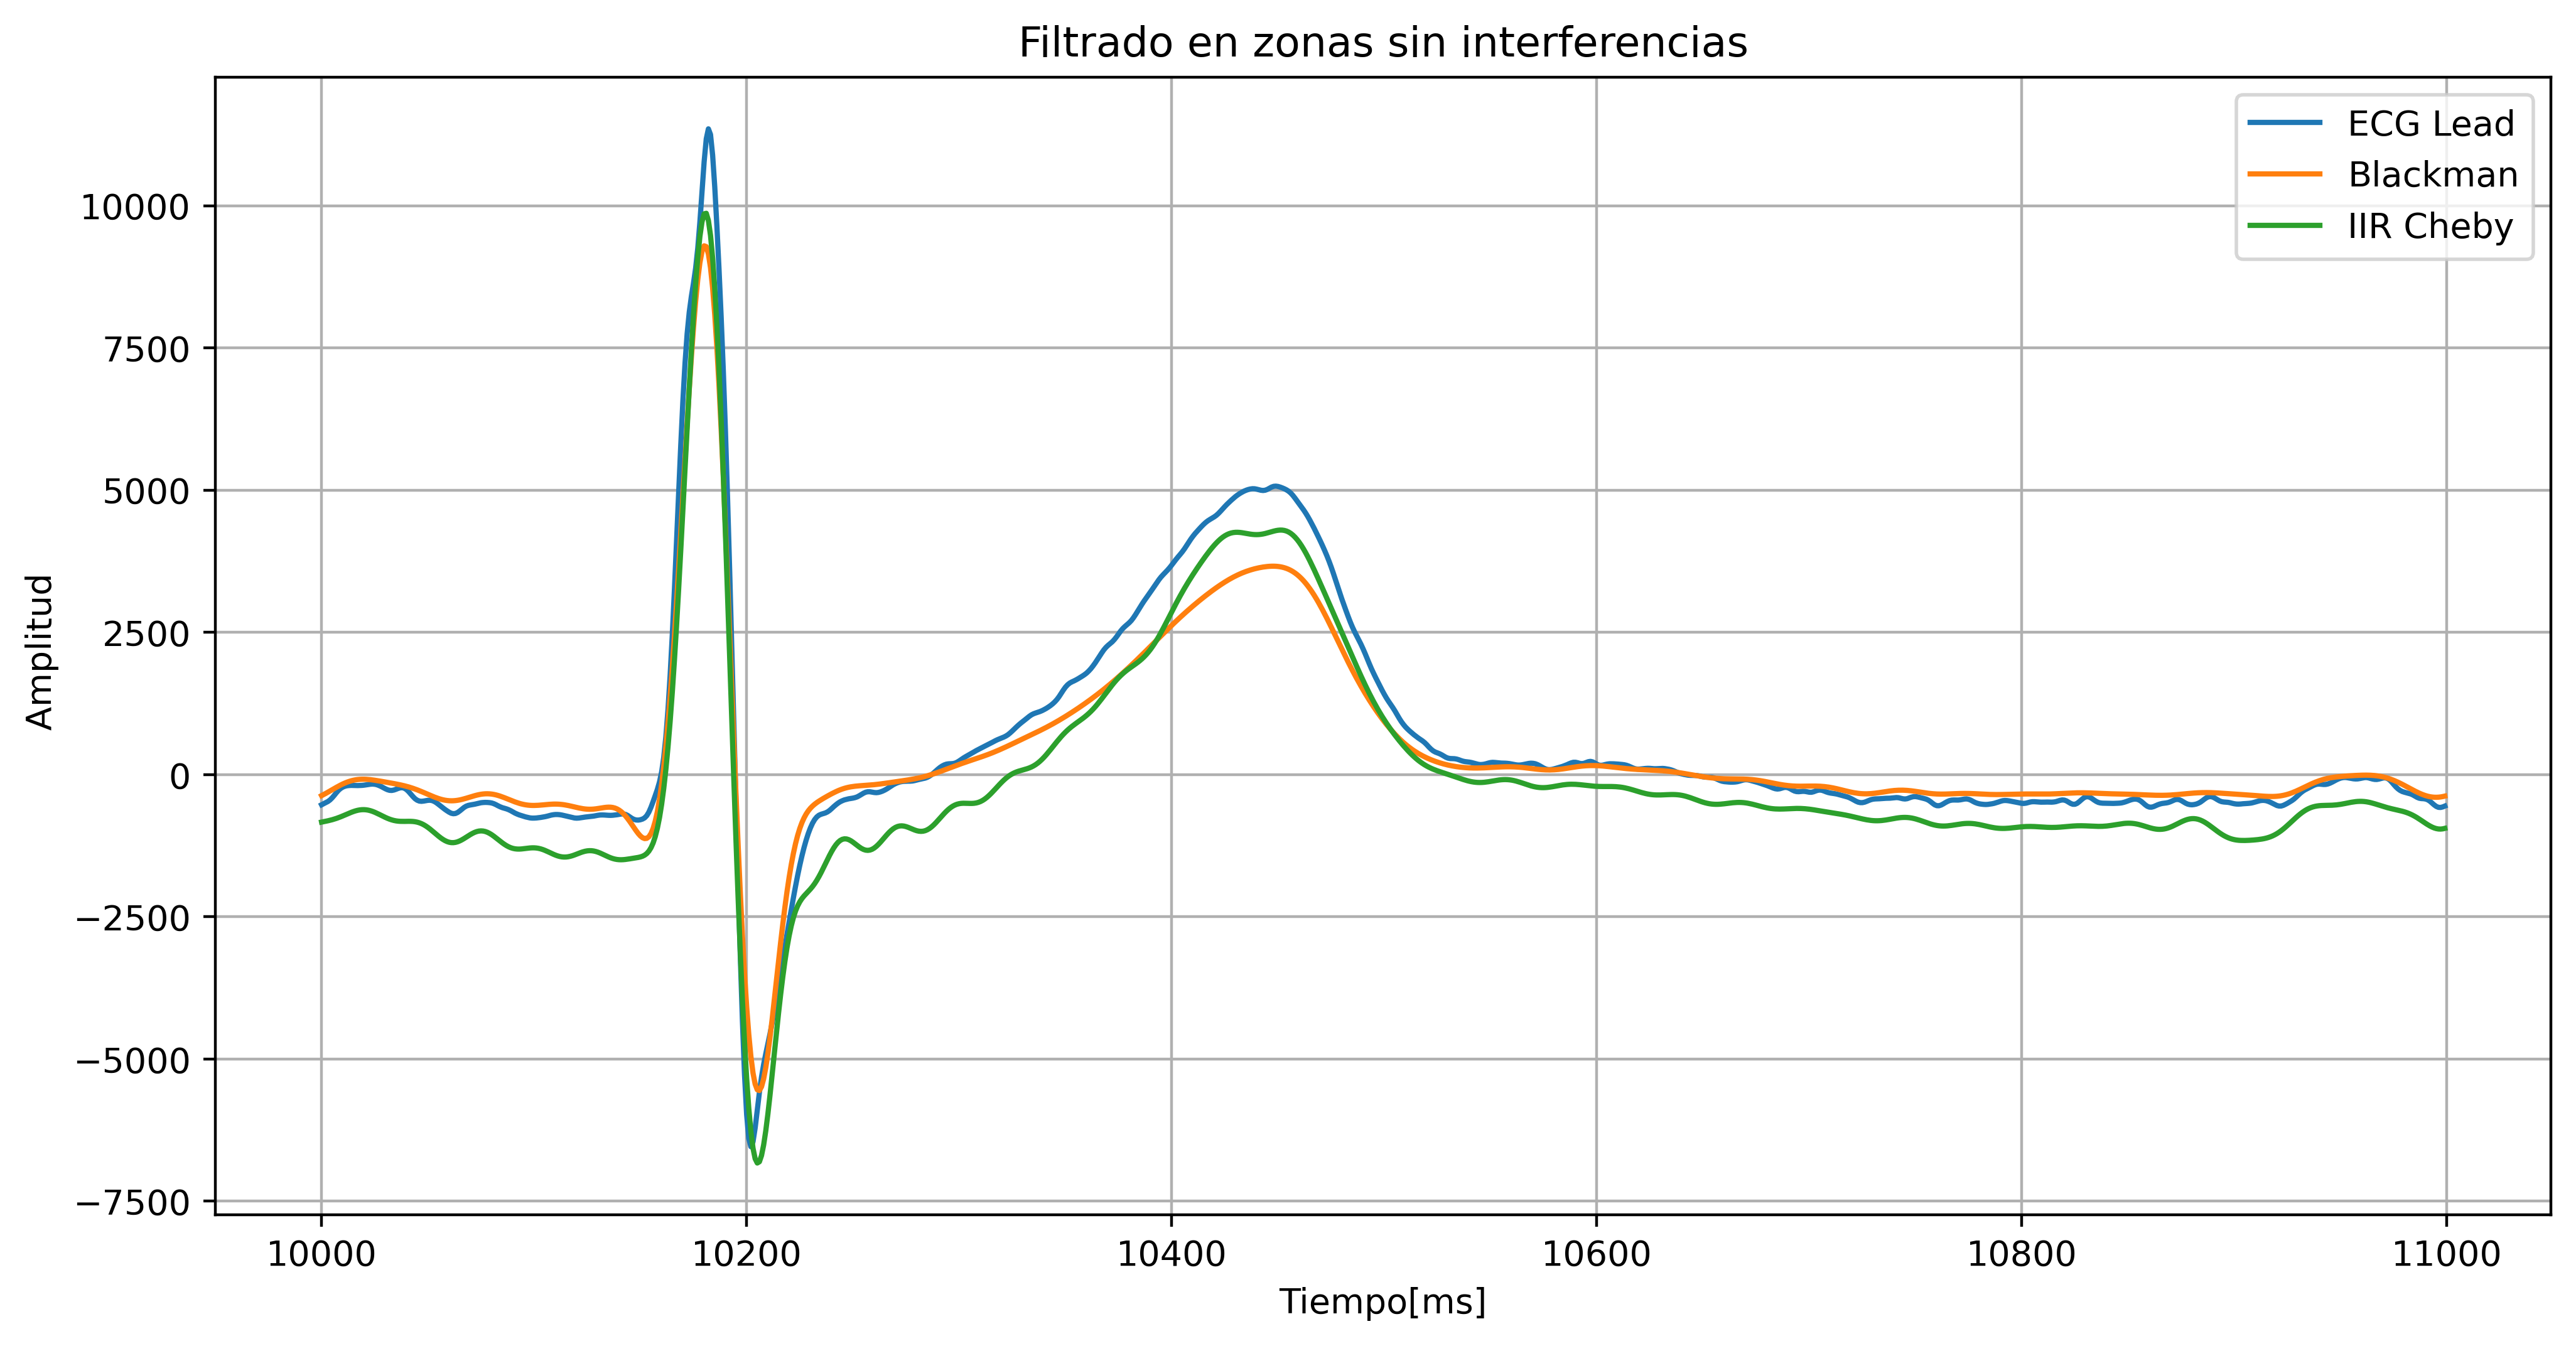

In [9]:
zonas_sin_interf = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for i in zonas_sin_interf:
    zoom = np.arange(i[0],i[1],dtype='int')
    
    plt.figure(figsize=[12,6],dpi=400)
    plt.plot(zoom,ecg_lead[zoom],label='ECG Lead')
    plt.plot(zoom,ECG_filtrada_black[zoom], label='Blackman')
    #plt.plot(zoom,ECG_filtrada_butter[zoom], label='IIR Butter')
    plt.plot(zoom,ECG_filtrada_cheby[zoom], label='IIR Cheby')
    
    plt.title('Filtrado en zonas sin interferencias')
    plt.xlabel('Tiempo[ms]')
    plt.ylabel('Amplitud ')
    plt.grid(which='both', axis='both')

    filtro_sin_interf = plt.gca()
    filtro_sin_interf.legend()

### Análisis y conclusiones

Observando los resultados de nuestros filtros podemos destacar que tanto el IIR como el FIR se comportan como queríamos, es decir, vemos que ambos filtran sobre las zonas con interfencias y son inocuos en lugares donde esta no aparece. Sin embargo, vemos una distorsión llamada <b>'ringing'</b>. El ringing es mucho más pronunciado en los filtros IIR que en los FIR debido a la distorsión de fase propia de la metodología lineal utilizada. Los FIR cuentan con una fase lineal, por lo que no cuenta con esta distorsión, aunque si observamos los resultados, notaremos que los FIR no producen un filtrado tan eficiente como sus primos IIR. 
Concluyendo, en los dos contamos con una relación de compromiso entre distorsión y mitigación, no podemos decir que uno es mejor que el otro ni que la metodología lineal de filtrado es un método totalmente óptimo de filtrado, si una forma de implementación fácil y comprensible.

---





## Referencias

J. Malmivuo y R. Plonsey,(1995). <i>Bioelectromagnetism - Principles and Applications of Bioelectric and Biomagnetic Fields</i>.

L. Sörnmo y P. Laguna, (2005). <i>Bioelectrical Signal Processing in Cardiac and Neurological Applications</i>.

A. Natale y O. Wazni,(2007). <i>Handbook of Cardiac Electrophysiology</i>.

R. Lyons, (2001).  <i>Understanding Digital Signal Processing</i>.

M. Hayes, (1996). <i>Statistical Digital Signal Processing and Modeling</i>.